# Case Studies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [15]:
def read_file(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def read_file2(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles2/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data


def cumulative_sfh(name, halo_num):
    age = 13.800797497330507
    if name=='h148':
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/h148.cosmo50PLK.3072g3HbwK1BH.004096')
    else:
        s = pynbody.load('/home/christenc/Data/Sims/'+name+'.cosmo50PLK.3072g/'+name+'.cosmo50PLK.3072gst5HbwK1BH/snapshots/'+name+'.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar 
    return c_sfh, age-bincenters

In [17]:
def CaseStudyPlots(simulation_name,i,showram=True,filename=True):

    data = read_file2(simulation_name, i)
    # data[:10]

    age = 13.800797497330507
    q_thresh = 0.9
    i_thresh = 1.0
    
    print('Gathering data...')
    time = age - np.array(data['time'], dtype=float)
    gasfrac = np.array(data['gasfrac'], dtype=float)
    gastemp = np.array(data['gtemp'], dtype=float)
    ratio = np.array(data['ratio'], dtype=float)
    dist = np.array(data['h1dist'], dtype=float)
    SNHf = np.array(data['SNHfrac'], dtype=float)
    fHI = np.array(data['fHI'], dtype=float)
    mvir = np.array(data['mass'], dtype=float)
    HIratio = np.array(data['HIratio'], dtype=float)
    mHI = np.array(data['HIratio'],dtype=float)*np.array(data['mstar'],dtype=float)
    mgas = np.array(data['mgas'],dtype=float)
    c_sfh, bc = cumulative_sfh(simulation_name, i)

    shaded_min = -1
    shaded_max = 500*np.max(mgas)

    fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=100)
    ax.plot(time,dist,'g-')
    ax.invert_xaxis()
    ax.set_xlabel('Lookback Time [Gyr]')
    label3 = ax.set_ylabel(r'Distance from Host [$R_{\mathrm{vir}}$]')
    label3.set_color('g')
    ax.semilogy()
    ax.set_xlim(14,0)
    ax.set_ylim(0.1, 25)

    ax1 = ax.twinx()
    ax1.plot(time,ratio,'m-')
    label4 = ax1.set_ylabel(r'$P_{\mathrm{ram}} / P_{\mathrm{rest}}$')
    label4.set_color('m')
    try:
        ax1.set_ylim(np.min(ratio[~np.isnan(ratio)])-0.3, np.max(ratio[~np.isnan(ratio)])+1)
    except:
        ax1.set_ylim(0., 10)
    npeaks = 1
    peak_indices = np.argsort(ratio[~np.isnan(ratio)])[-npeaks:]


    ax.fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for index in peak_indices:
        t = time[~np.isnan(ratio)][index]
        ax.plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)

    if showram:
        plt.show()

    fig, ax = plt.subplots(1,3,figsize=(18,4),dpi=300)
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for i in [0,1,2]:
        for index in peak_indices:
            t = time[~np.isnan(ratio)][index]
            ax[i].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)


    ax[0].plot(bc, c_sfh, 'r-')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('Lookback Time [Gyr]')
    label1 = ax[0].set_ylabel('Cumulative, Normalized SFH')
    label1.set_color('r')
    ax[0].set_ylim(-0.05,1.05)
    ax[0].set_xlim(14,0)

    ax0 = ax[0].twinx()
    ax0.plot(time,HIratio,'b-')
    ax0.set_ylim(-1,3)
    label2 = ax0.set_ylabel(r'$M_{\mathrm{HI}}\ /\ M_{*}$')
    label2.set_color('b')
    t = np.max(bc[c_sfh >= 0.99])

    for i in [0,1,2]:
        ax[i].plot([t,t],[shaded_min,shaded_max], 'r--', linewidth=1)


    ax[1].plot(time,mHI,color='#370ec2',label='HI', linestyle='-')
    ax[1].plot(time,mgas,color='#370ec2',label='All Gas', linestyle='--')
    ax[1].set_xlabel('Lookback Time [Gyr]')
    label = ax[1].set_ylabel(r'Gas Mass [$M_{\odot}$]')
    label.set_color('#370ec2')
    ax[1].legend(frameon=False)
    ax[1].semilogy()
    ax[1].invert_xaxis()
    ax[1].set_xlim(14,0)
    allgas = np.append(mgas,mHI)
    allgas = allgas[(~np.isnan(allgas)) & (allgas!=0)]
    ax[1].set_ylim(0.5*np.min(allgas),1.4*np.max(allgas))

    ax1 = ax[1].twinx()
    ax1.plot(time,gastemp,'k-')
    ax1.invert_xaxis()
    ax1.set_xlabel('Lookback Time [Gyr]')
    ax1.set_ylabel('Mean Gas Temperature [K]')
    ax1.set_xlim(14,0)
    ax1.set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.05*np.max(gastemp[~np.isnan(gastemp)]))

    # ax[2].set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.4*np.max(gastemp[~np.isnan(gastemp)]))
    # ax[2].plot(time,data['outflow_temp_23'],label='Outflow')
    # ax[2].plot(time,data['inflow_temp_23'],label='Inflow')
    # ax[2].legend(frameon=False, prop={'size':9})
    # ax[2].semilogy()


    netflux = data['outflow_91'] + data['inflow_91']
    # ax[2].plot(time, netflux, color='#ad7617', linestyle='-')
    # ax[2].invert_xaxis()
    # label5 = ax[2].set_ylabel(r'Net Gas Flux [$M_{\mathrm{\odot}}\ \mathrm{yr}^{-1}$]')
    # label5.set_color('#ad7617')
    # ax[2].set_ylim(1.2*np.min(netflux),1.2*np.max(netflux))
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min,shaded_max, where=(netflux < 0.), edgecolor='none',alpha=0.2, facecolor='#ad7617')

    ax[2].invert_xaxis()
    ax[2].plot(time,abs(data['outflow_91']), color='r',label='outflow')
    ax[2].plot(time,abs(data['inflow_91']), color='orange', label='inflow')
    ax[2].set_ylabel('Outflow Rate / Inflow Rate')
    ax[2].legend(frameon=False)
    alloutflows = np.append(abs(data['outflow_91']),abs(data['inflow_91']))
    alloutflows = alloutflows[~np.isnan(alloutflows)]

    if (alloutflows == 0.).all():
        ax[2].set_ylim(-0.001,0.001)
    else:
        ax[2].set_ylim(-0.001,1.3*np.max(alloutflows))
    ax[2].set_xlim(14,0)

    ax2 = ax[2].twinx()
    ax2.plot(time,SNHf, c='b')
    label = ax2.set_ylabel('SN Heated Fraction')
    label.set_color('b')


    plt.subplots_adjust(wspace=0.45)
    if filename:
        f = 'case_study_'+str(simulation_name)+'_'+str(i)+'.png'
        plt.savefig('CaseStudyPlots/'+f, dpi=300)
    else:
        plt.savefig('CaseStudyPlots/'+str(filename), dpi=300)
    plt.show()

# Quenched Before Infall

Gathering data...


<Figure size 432x288 with 0 Axes>

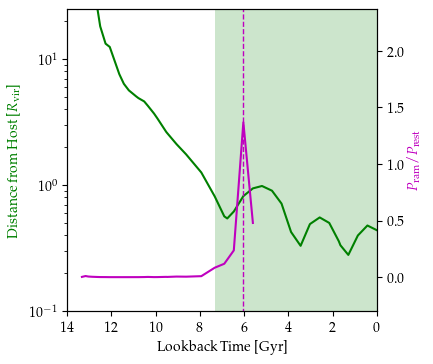

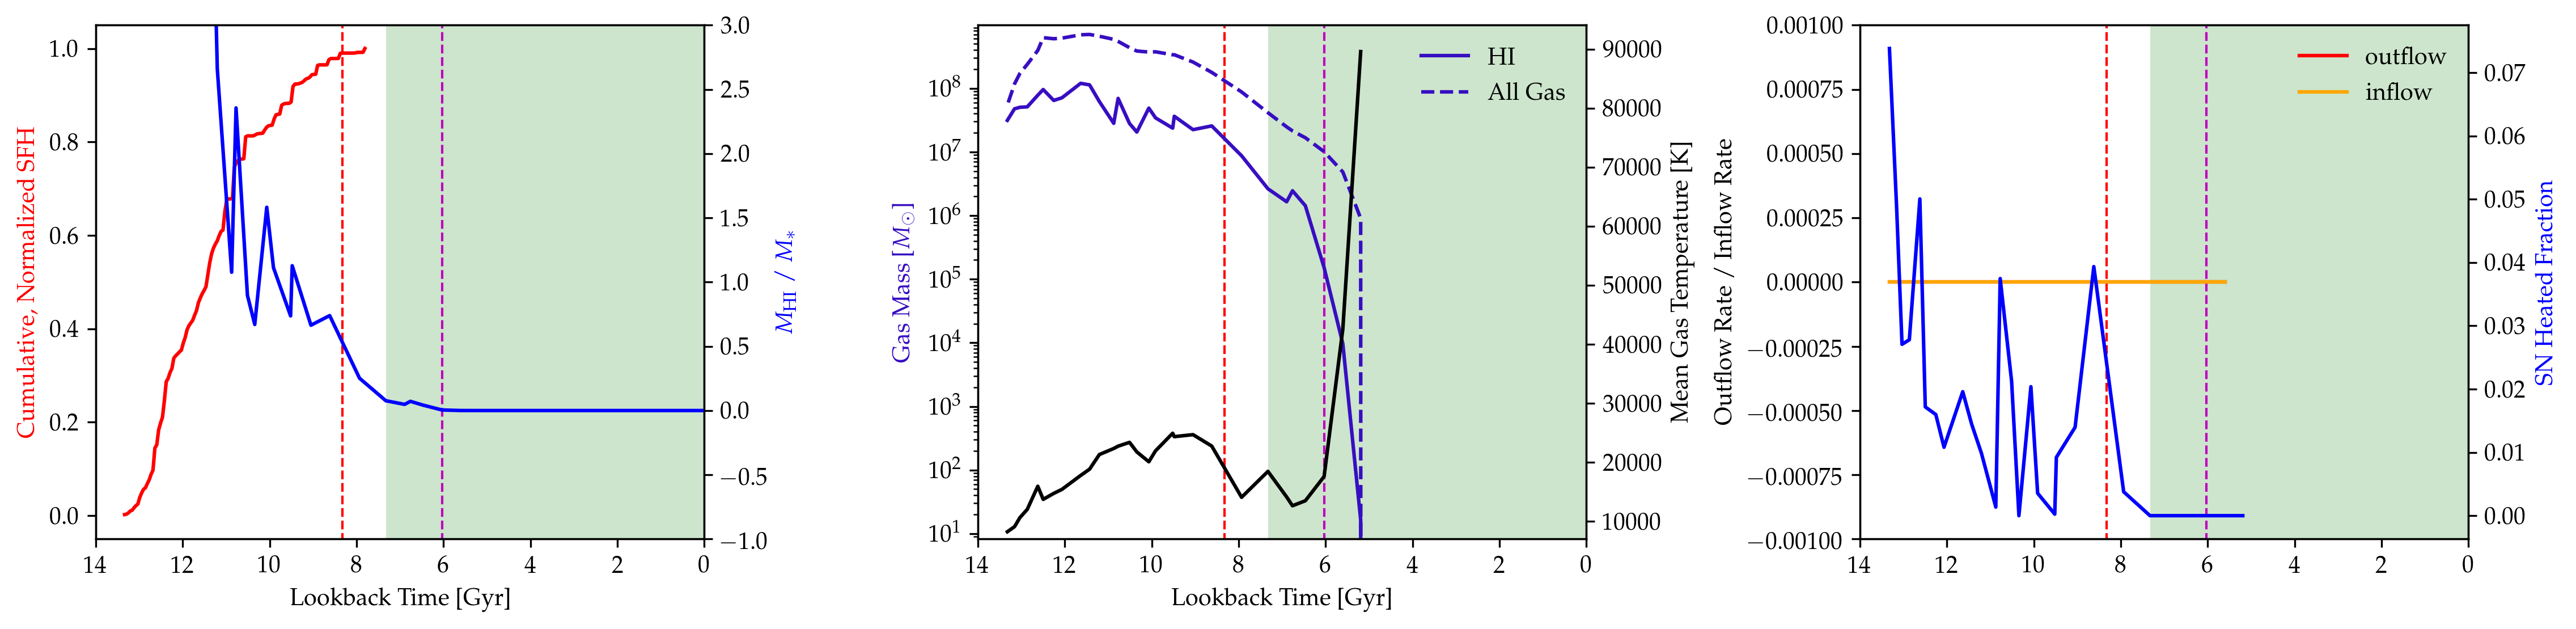

In [26]:
CaseStudyPlots('h148',62)

In [ ]:
CaseStudyPlots('h229',24)

In [ ]:
CaseStudyPlots('h242',27)

Gathering data...


<Figure size 432x288 with 0 Axes>

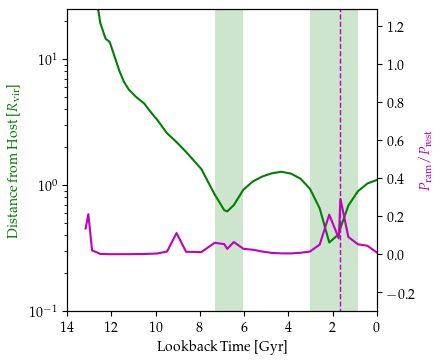

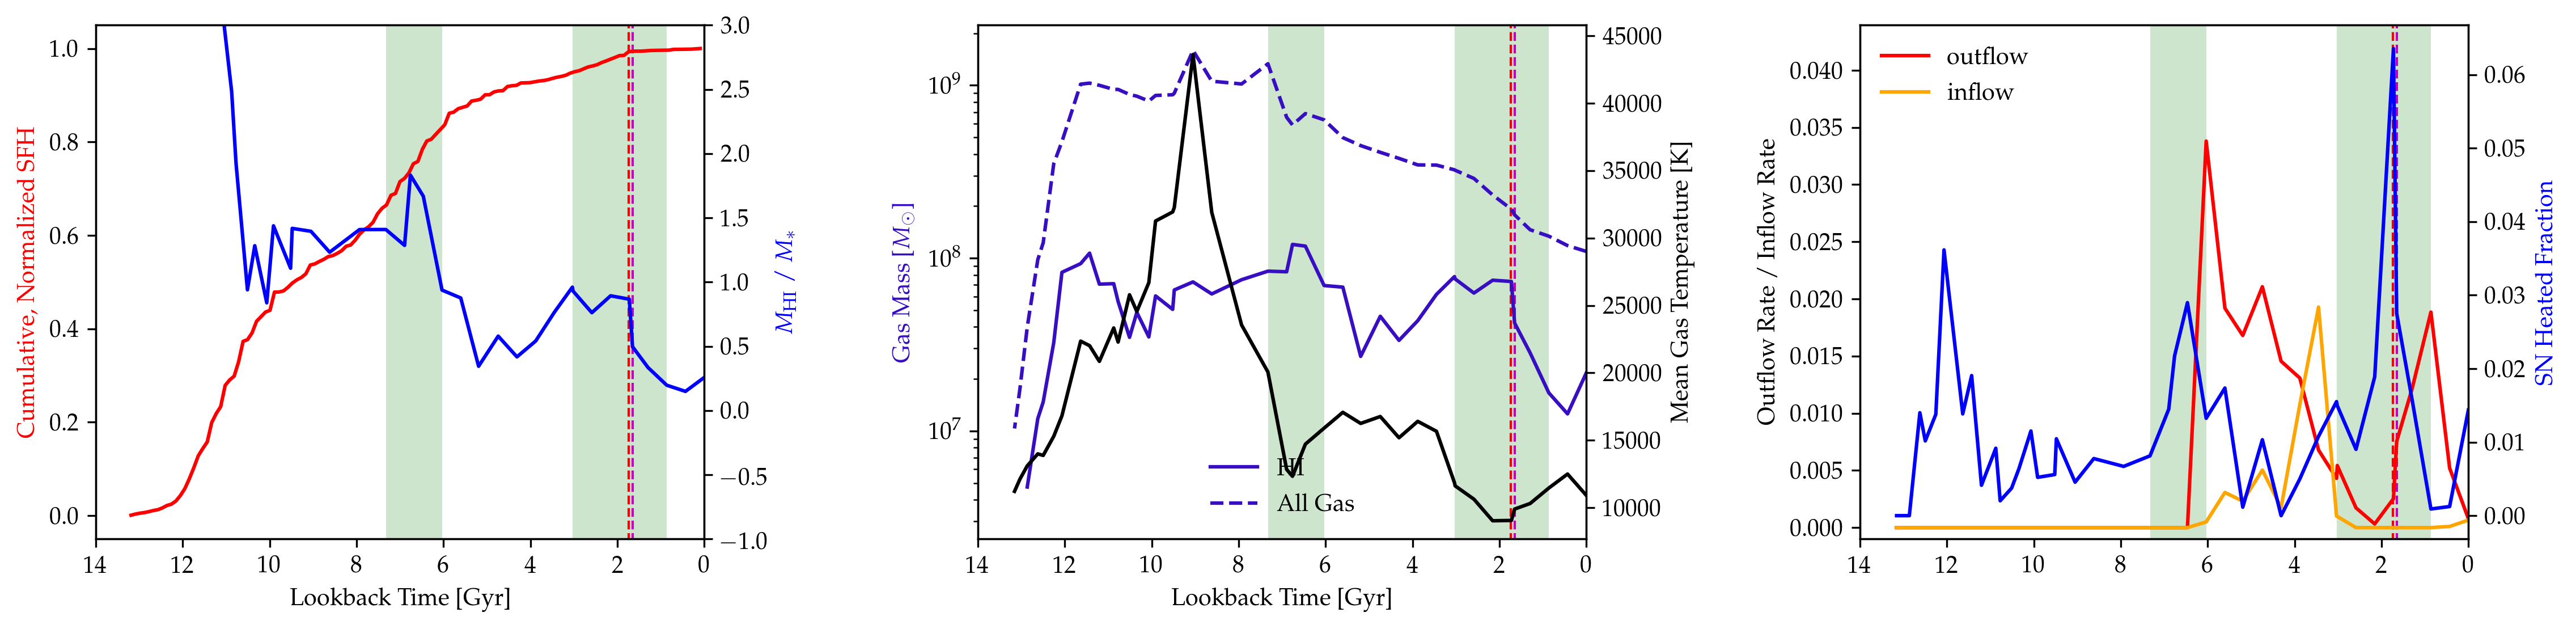

In [40]:
CaseStudyPlots('h148', 27)

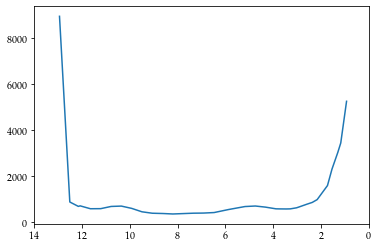

In [28]:
data = read_file('h148',36)
plt.plot(data.time,data.env_rho)
plt.xlim(14,0)
plt.show()

Gathering data...


<Figure size 432x288 with 0 Axes>

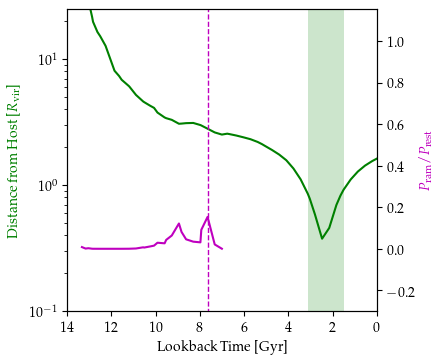

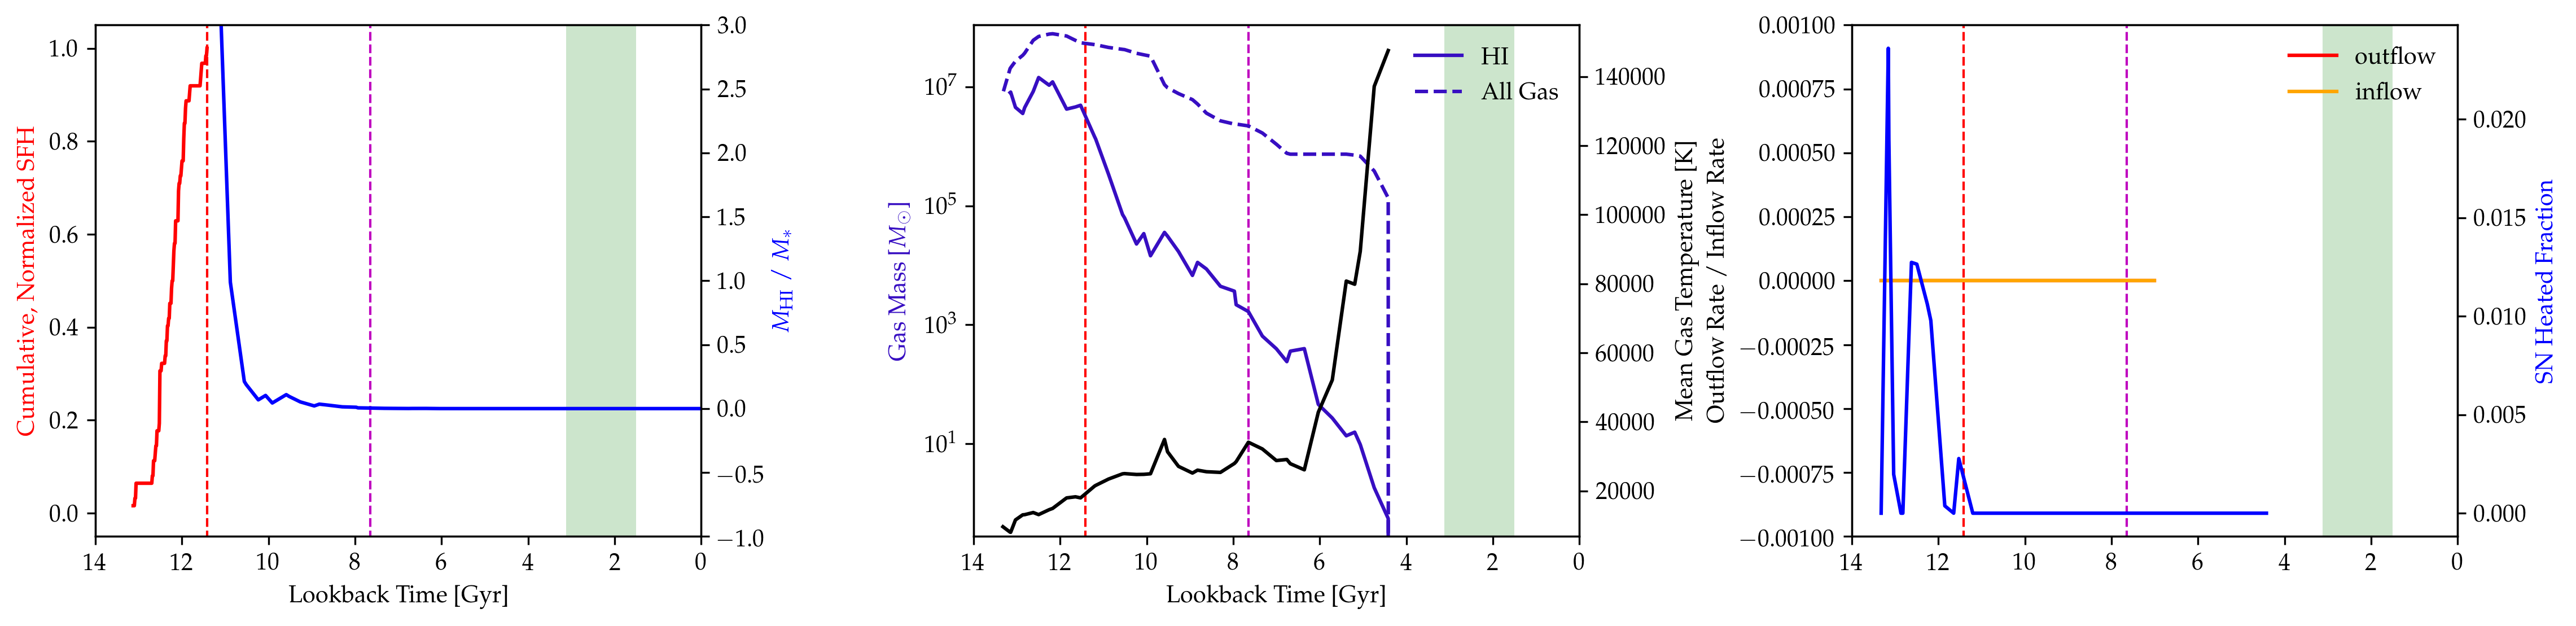

In [29]:
CaseStudyPlots('h242',81)

In [32]:
data = read_file('h242',81)
t_depl = data.mHI[data.sfr != 0.] / data.sfr[data.sfr != 0.]
for t, t_depl in zip(data.time[data.sfr != 0.], t_depl):
    print(t,'\t',t_depl/1e9)

2.272072320943119 	 23.401473726400518
1.9488370356051148 	 12.91605362336402
1.6256017502673068 	 21.38794983729369
1.5447929289331561 	 32.015319238992355
1.3023664649298075 	 19.834961000786976
1.1777861987084002 	 41.736482937989436
0.7670080235986003 	 21.9964980060777
0.6558958942651686 	 120.85313195490833
0.6424277573762386 	 114.61658529093549


Gathering data...


<Figure size 432x288 with 0 Axes>

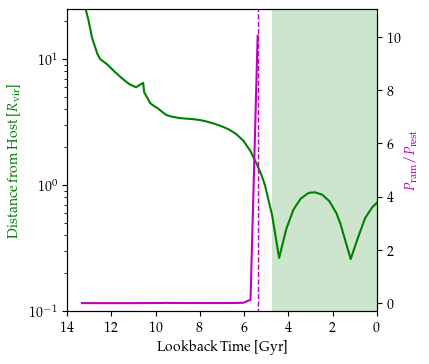

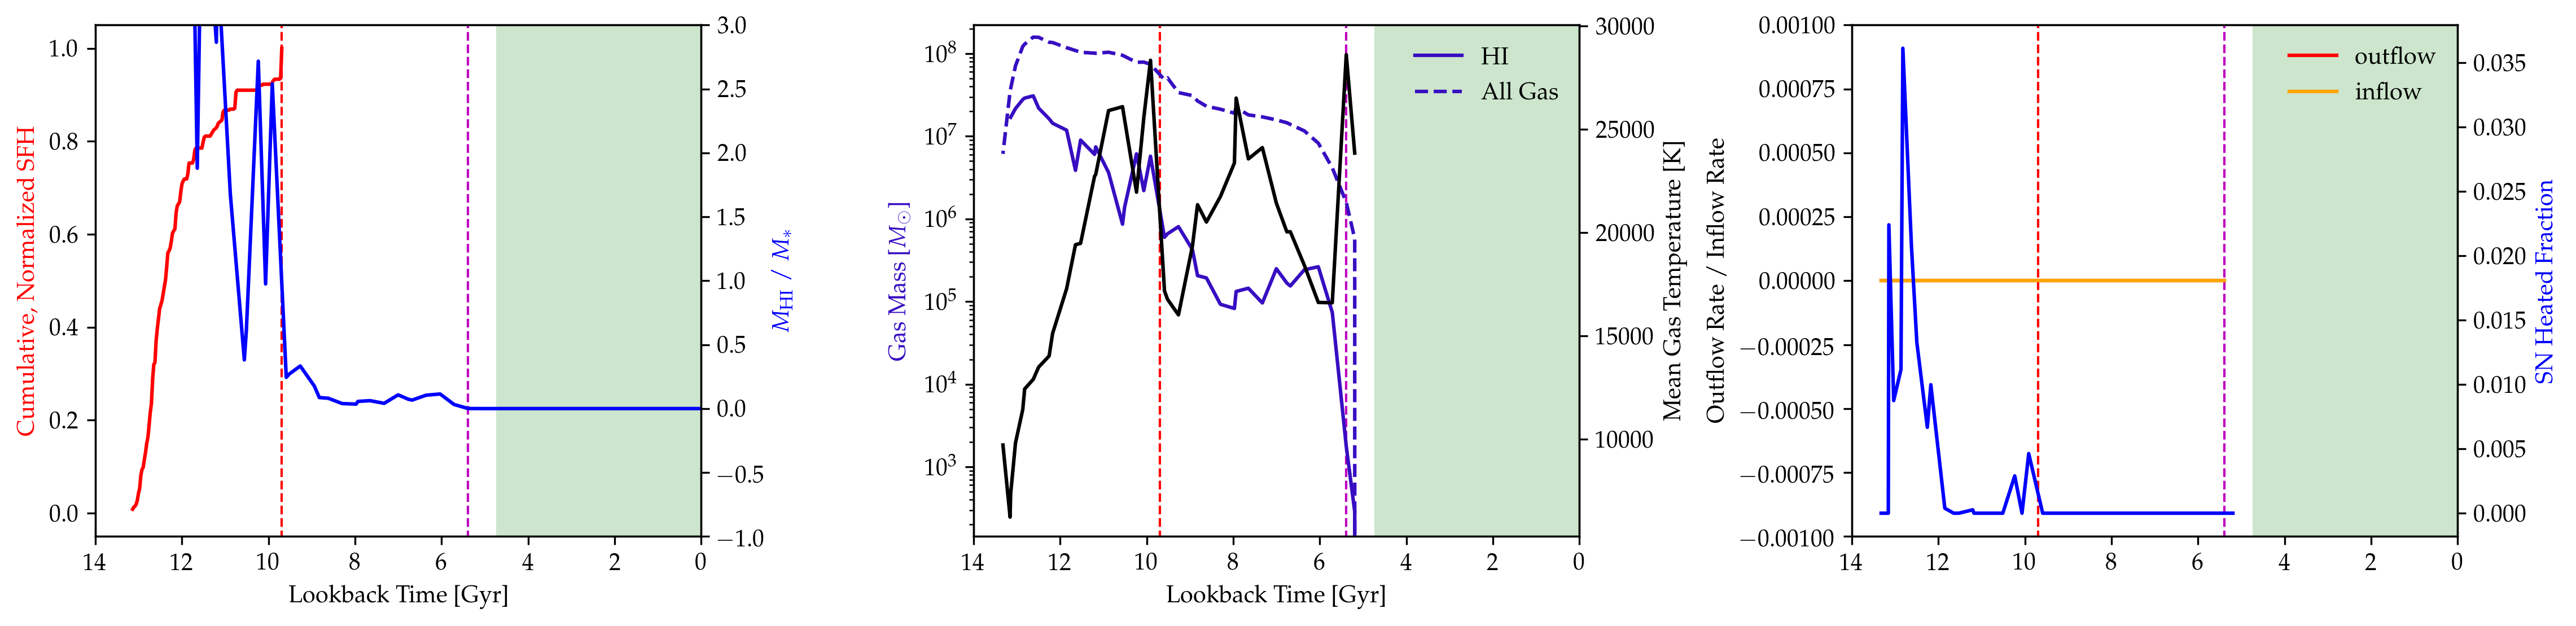

In [35]:
CaseStudyPlots('h229',91)

In [36]:
data = read_file('h229',91)
t_depl = data.mHI[data.sfr != 0.] / data.sfr[data.sfr != 0.]
for t, t_depl in zip(data.time[data.sfr != 0.], t_depl):
    print(t,'\t',t_depl/1e9)

4.211484032829669 	 0.4867733572992891
3.8882487475201 	 37.409123098639995
3.7333651733092665 	 33.112658589612366
3.565013462210532 	 27.4171654949626
2.622243880057796 	 17.551688321388255
2.595307606280711 	 14.747351006264775
2.154226123163353 	 3.8439036659297012
1.9488370356047835 	 26.03969986550074
1.625601750266745 	 11.213091797695267
1.5447929289322362 	 8.258683947398728
1.3023664649288766 	 6.305875946791165
1.177786198707049 	 9.304260123060528
0.9791311795963158 	 18.198794287344285
0.9353597347076276 	 15.888327557567015
0.7670080235976816 	 38.39843798050374
0.6558958942651286 	 230.1386957060725


Gathering data...


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)


<Figure size 432x288 with 0 Axes>

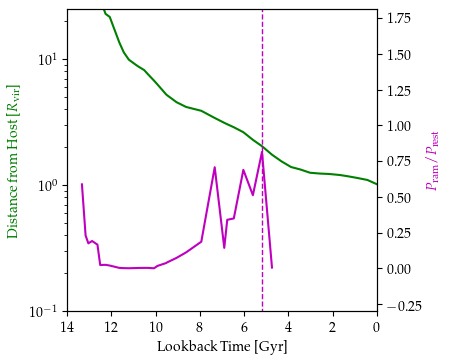

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater_equal


ValueError: zero-size array to reduction operation maximum which has no identity

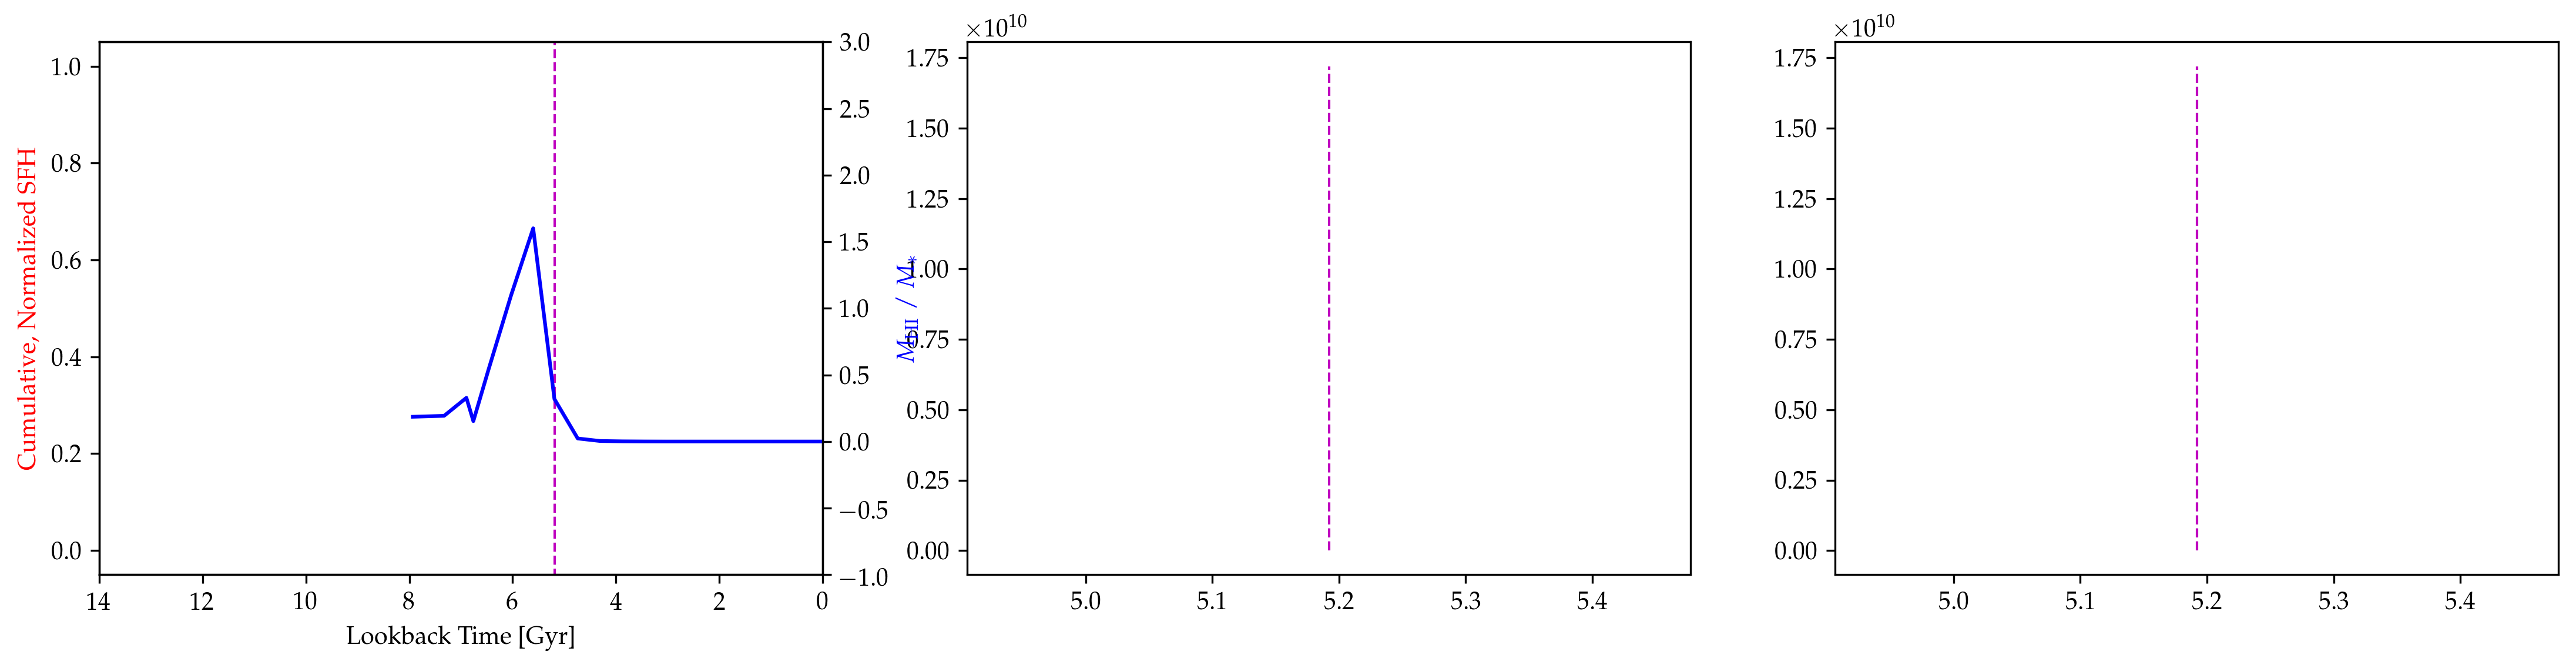

In [38]:
for i, sim in zip([44,52,90,189,31],['h148','h148','h148','h148','h329']):
    CaseStudyPlots(sim,i)

Gathering data...


<Figure size 432x288 with 0 Axes>

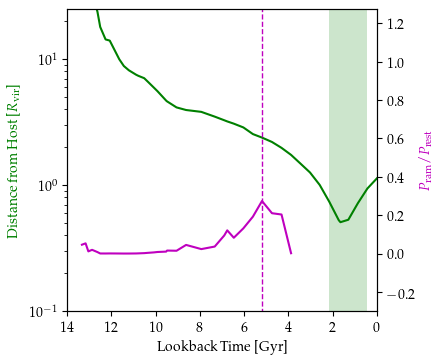

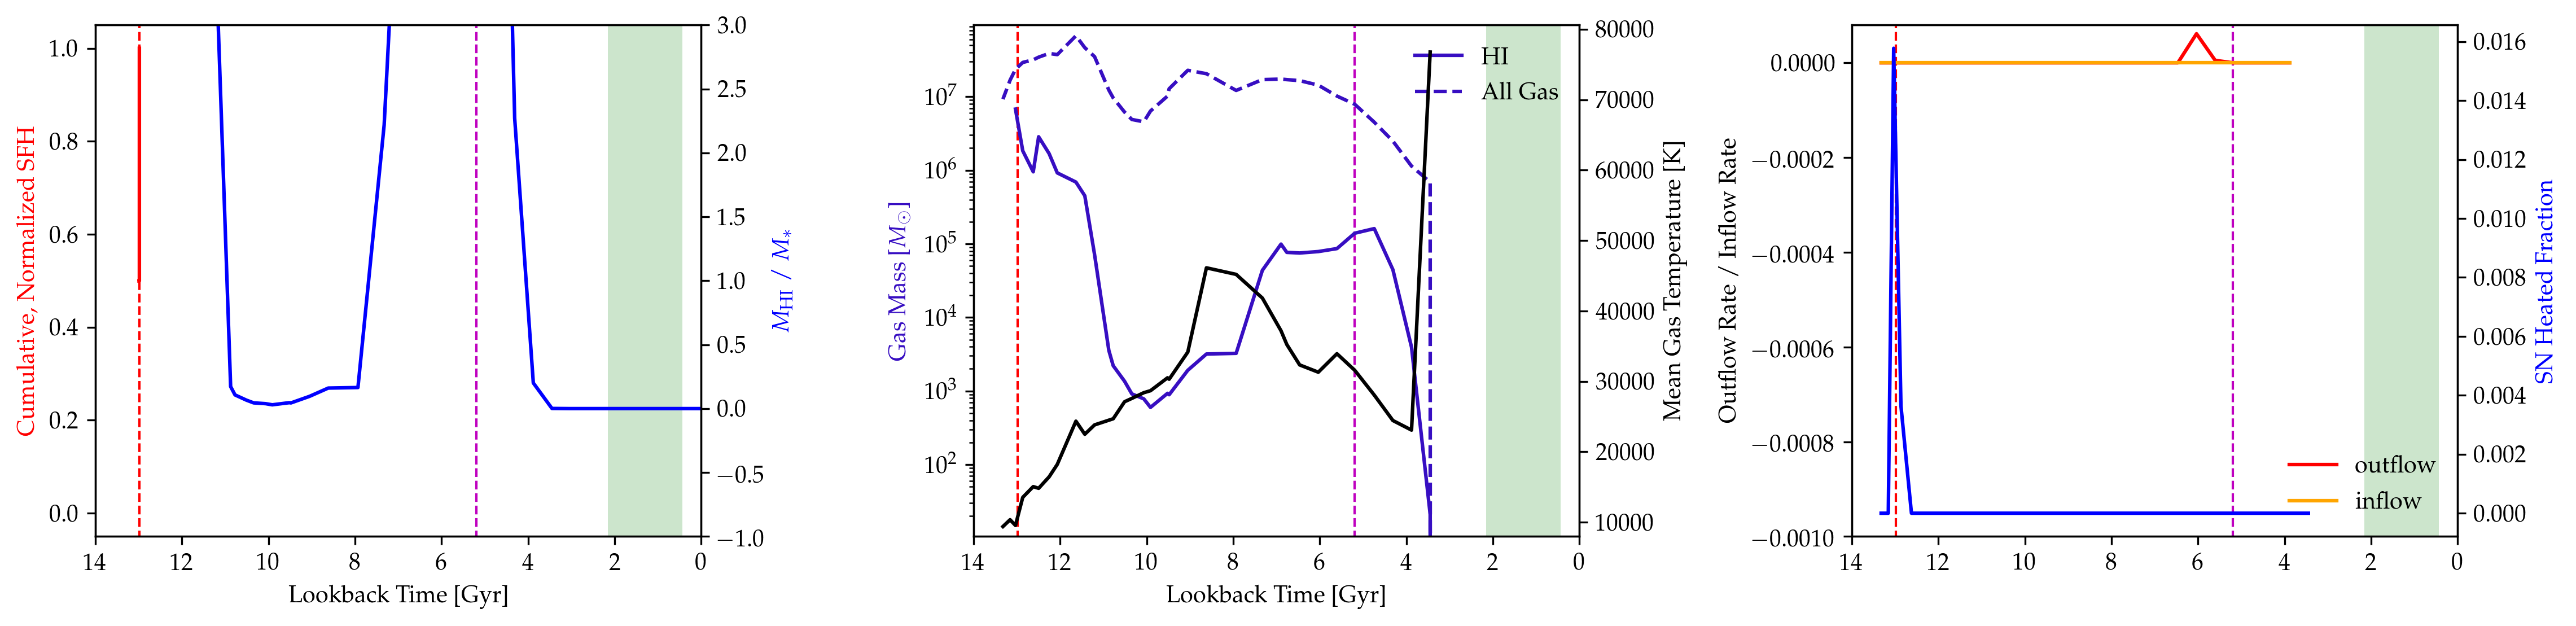

Gathering data...


<Figure size 432x288 with 0 Axes>

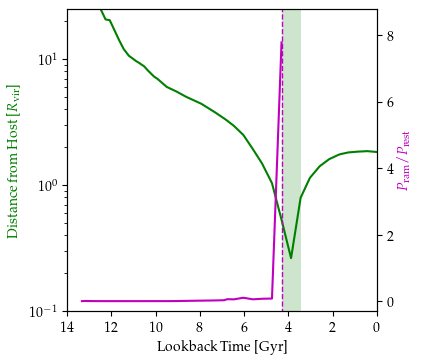

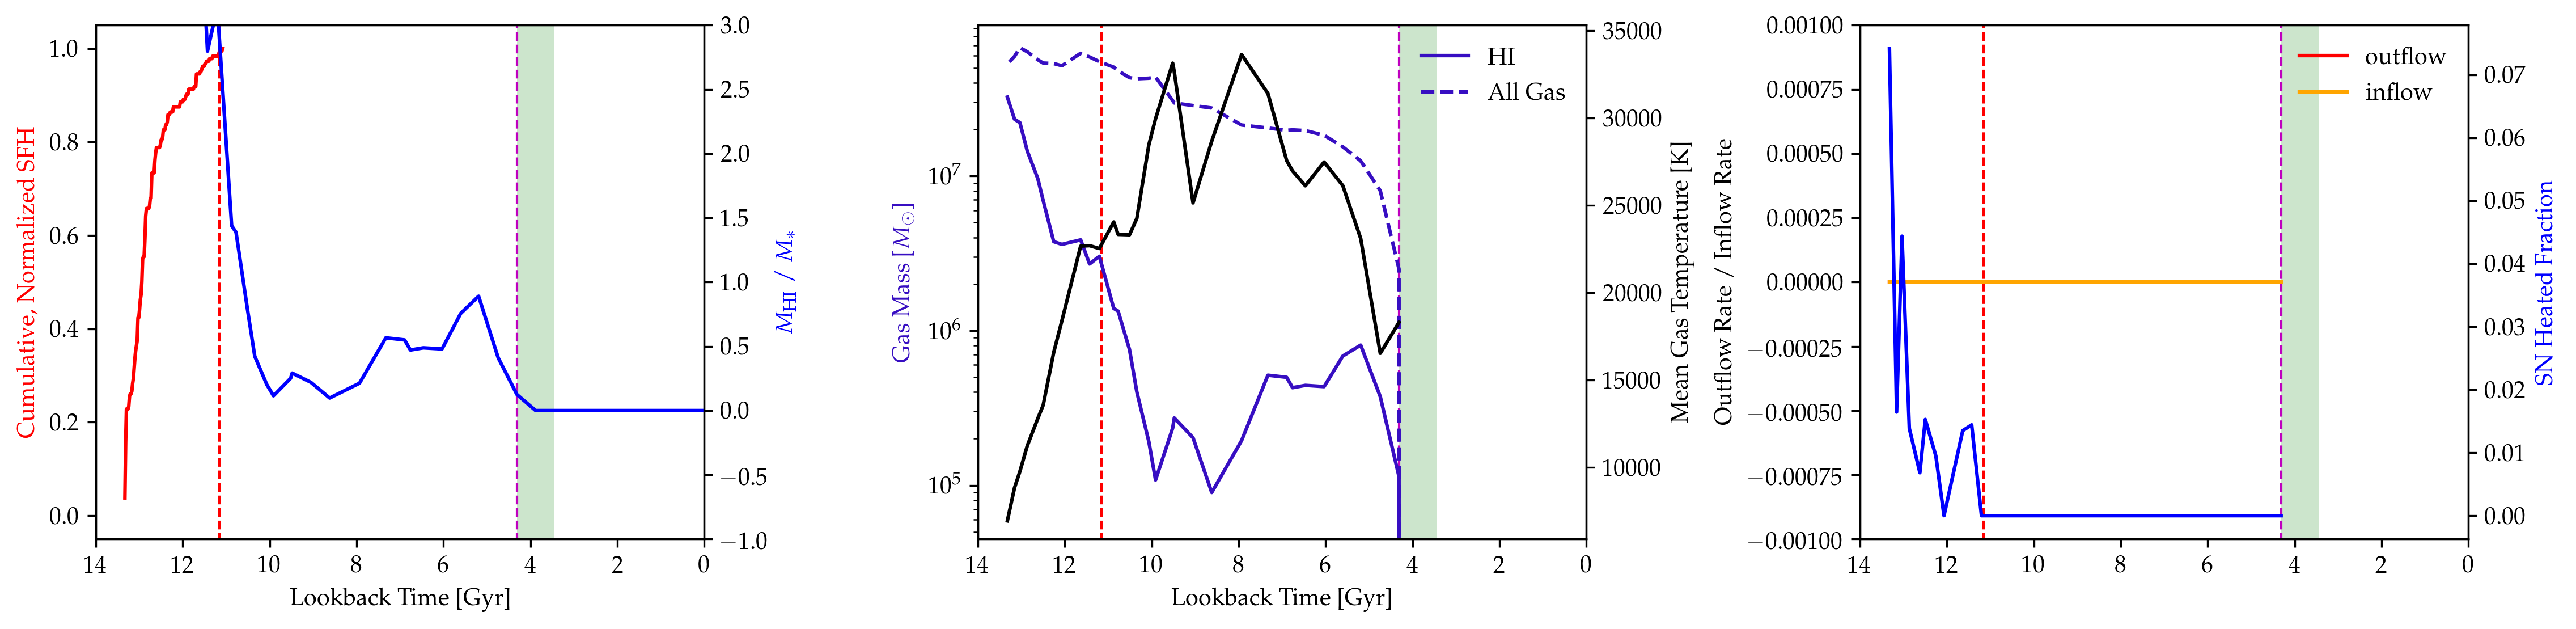

Gathering data...


<Figure size 432x288 with 0 Axes>

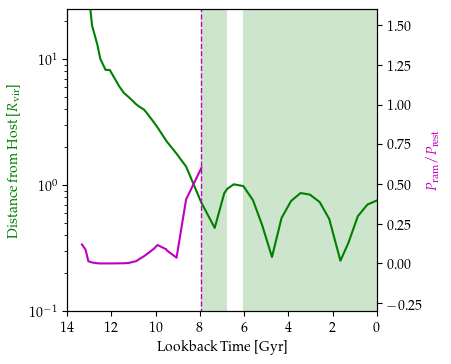

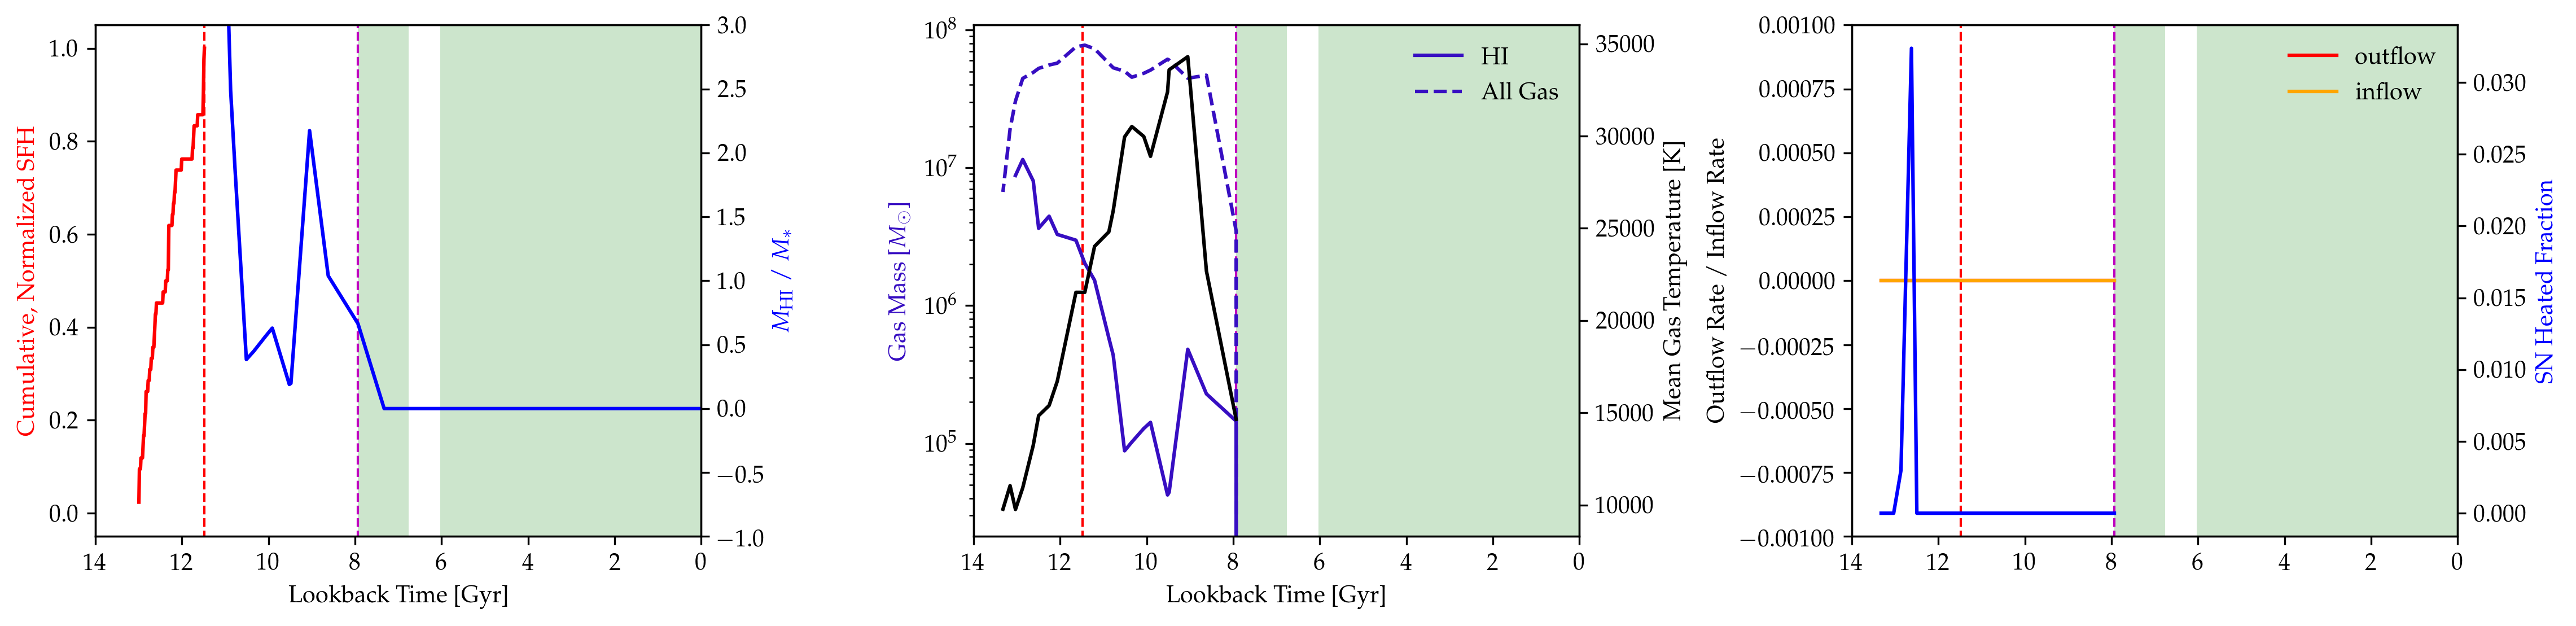

Gathering data...


<Figure size 432x288 with 0 Axes>

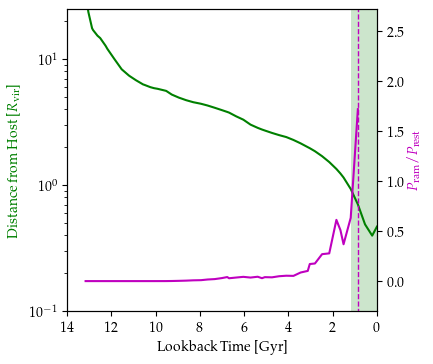

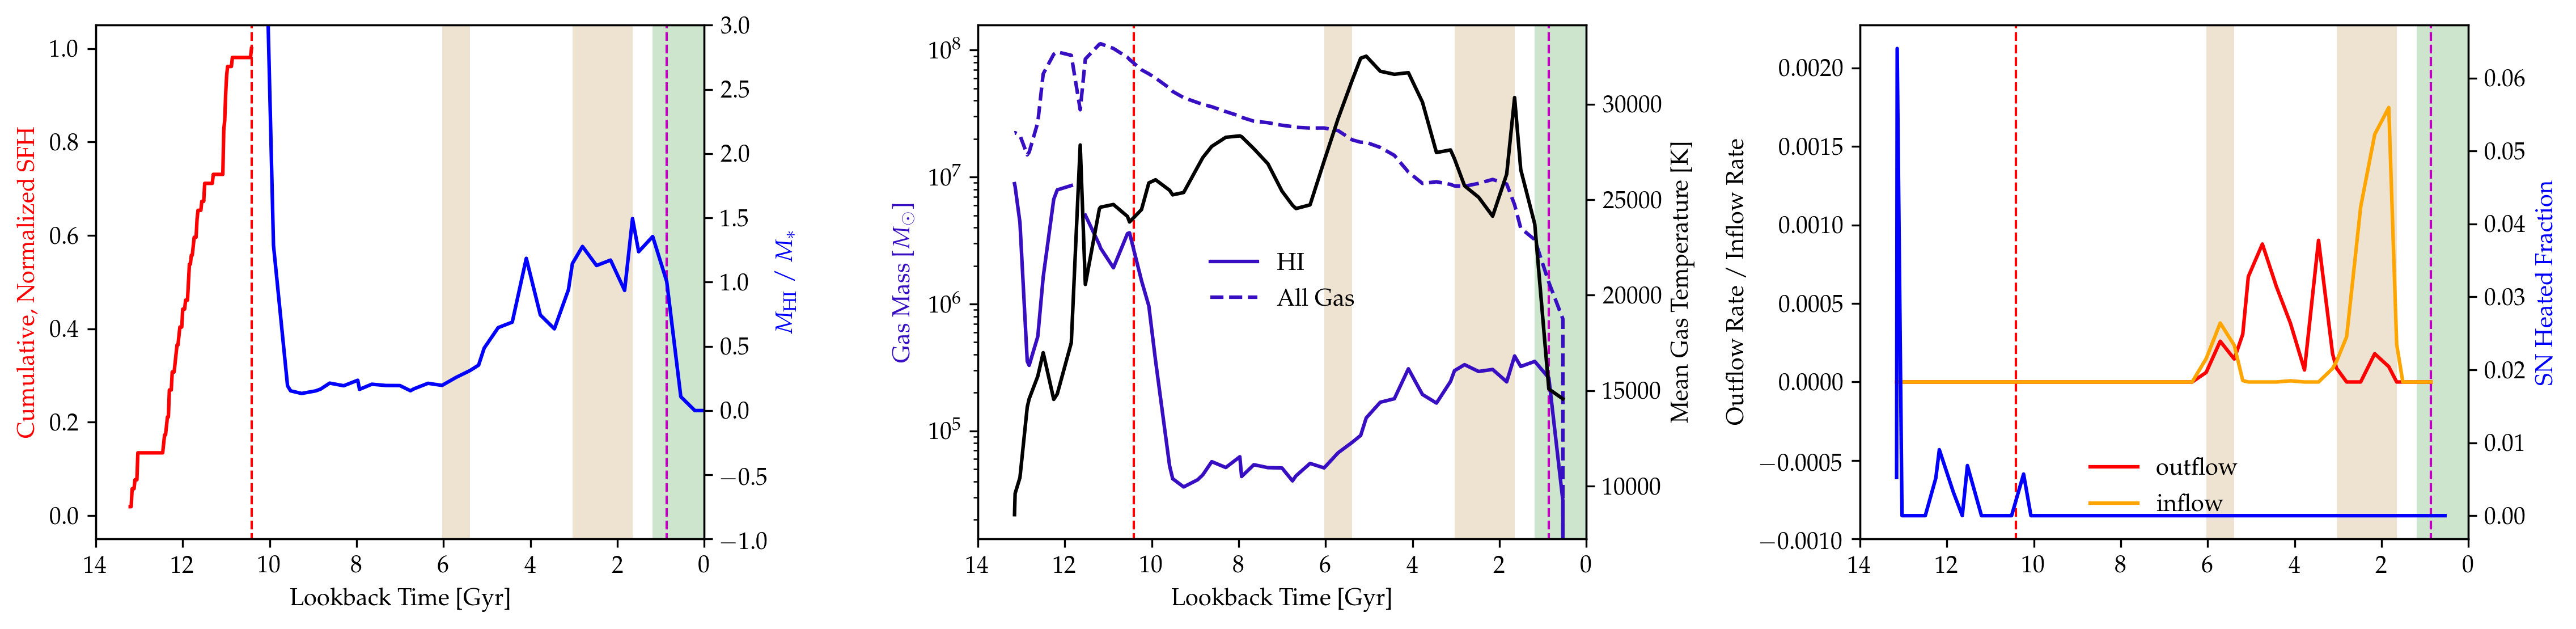

In [39]:
for i, sim in zip([52,90,189,31],['h148','h148','h148','h329']):
    CaseStudyPlots(sim,i)

Gathering data...


<Figure size 432x288 with 0 Axes>

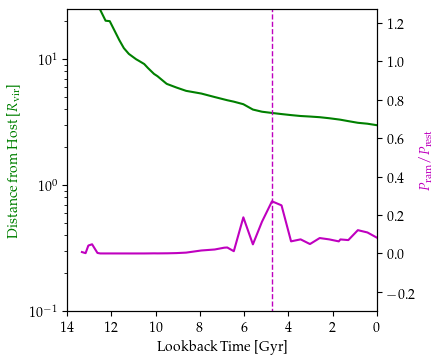

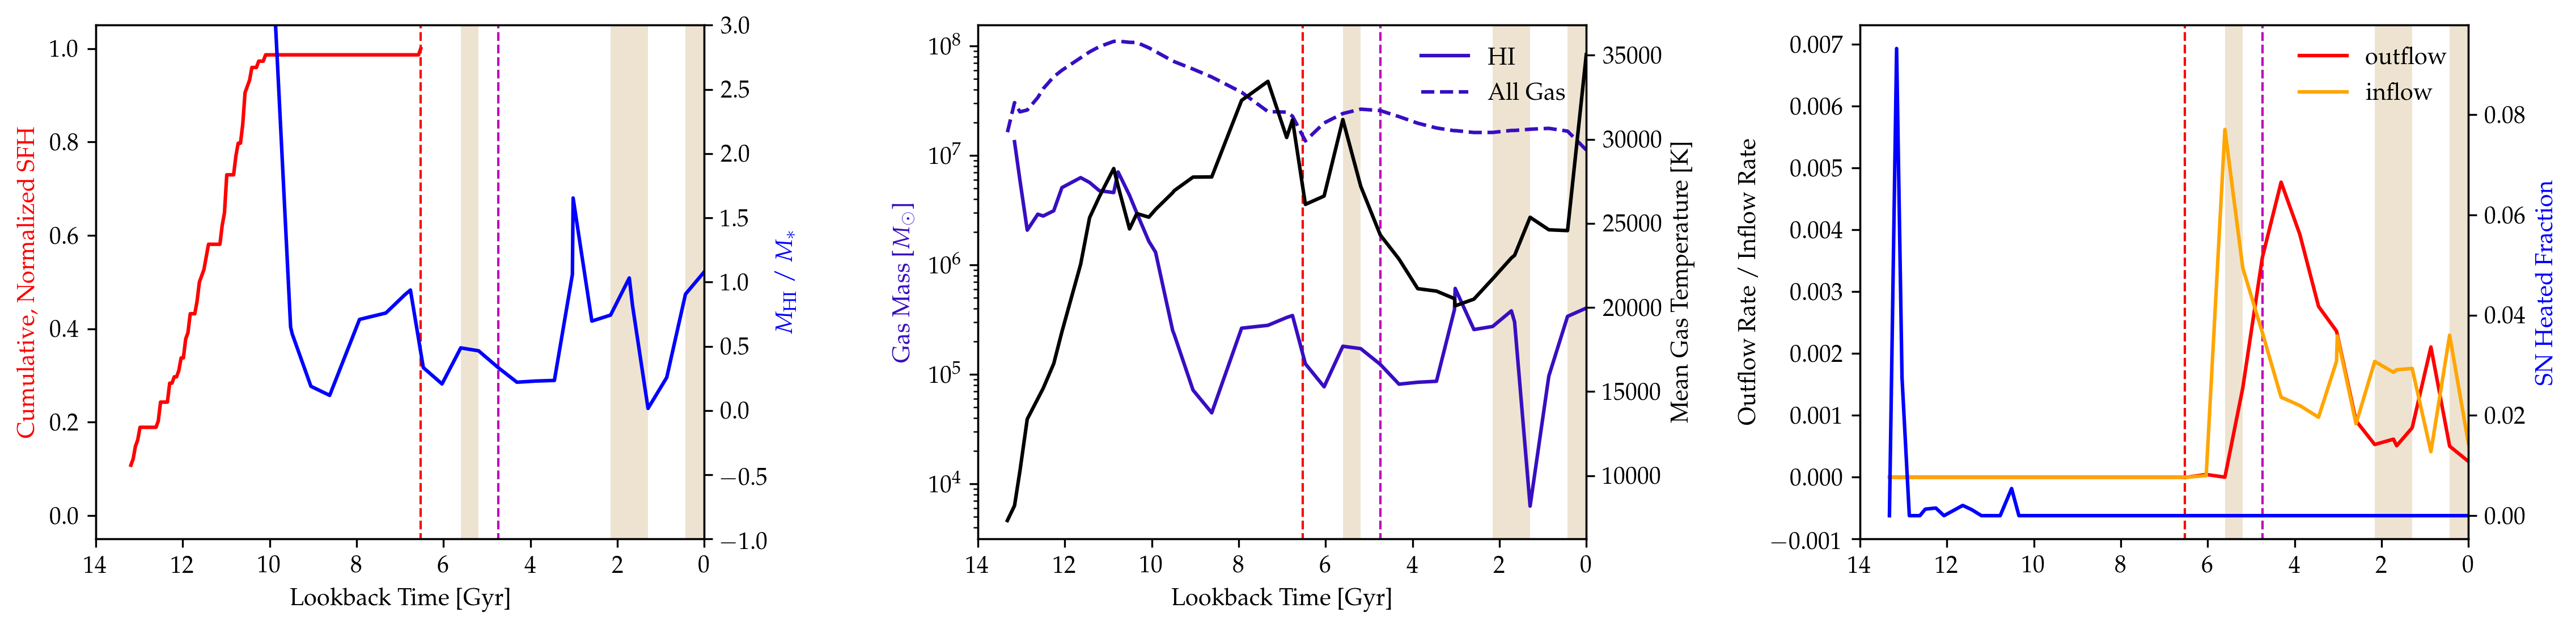

In [42]:
CaseStudyPlots('h148',29)

Gathering data...


<Figure size 432x288 with 0 Axes>

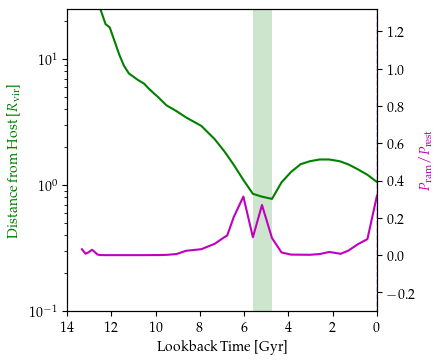

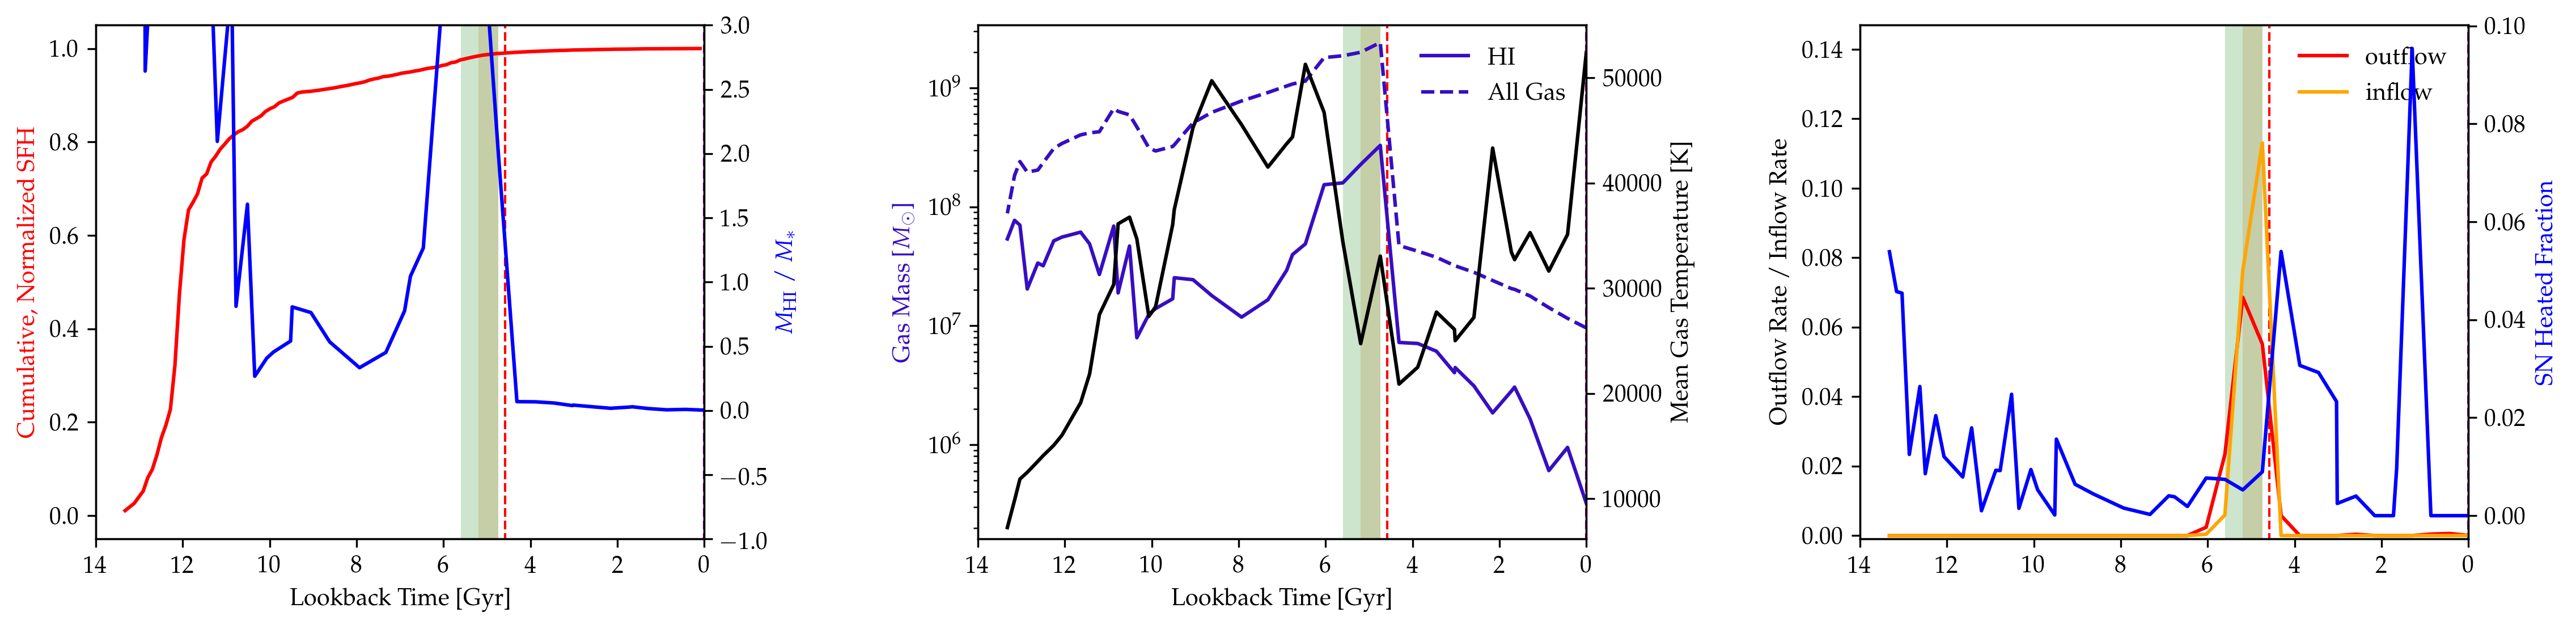

In [44]:
CaseStudyPlots('h148',12)

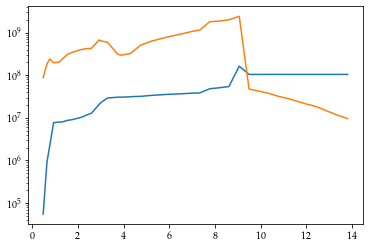

In [53]:
data = read_file('h148',12)
plt.plot(data.time, data.mstar)
plt.plot(data.time, data.mgas)
plt.semilogy()
plt.show()

Gathering data...


<Figure size 432x288 with 0 Axes>

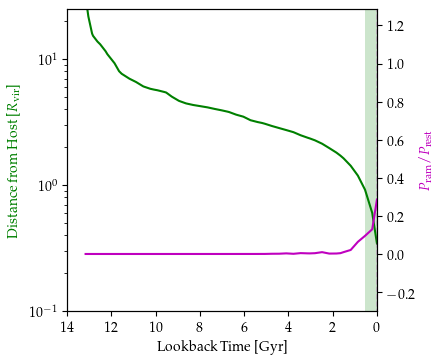

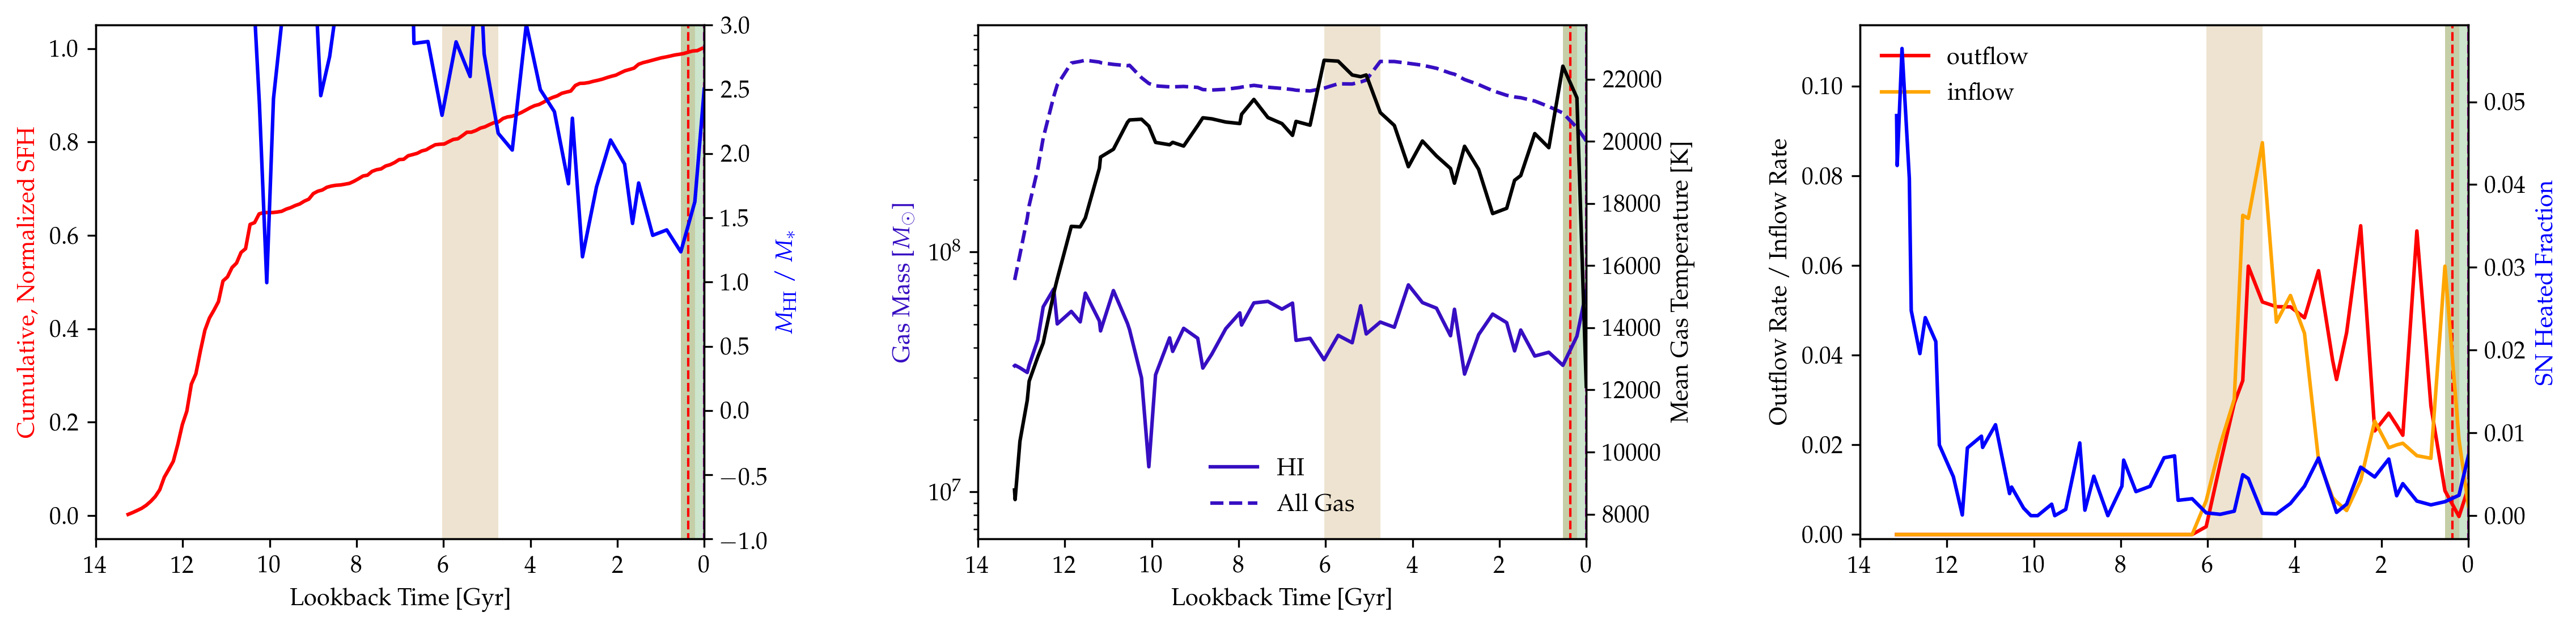

In [54]:
CaseStudyPlots('h329',7)

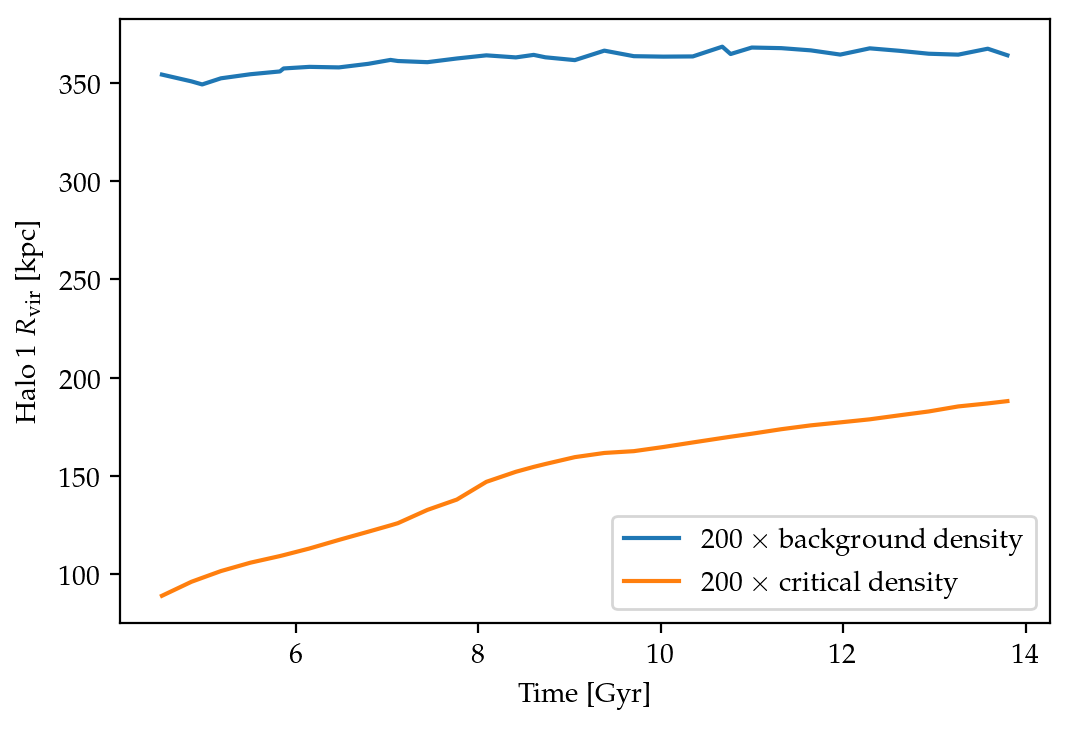

In [37]:
data = read_file2('h329',29)
plt.figure(dpi=200)
plt.plot(data.time,data.r200b, label=r'200 $\times$ background density')
plt.plot(data.time,data.h1dist_kpc/data.h1dist, label=r'200 $\times$ critical density')
plt.ylabel('Halo 1 $R_{\mathrm{vir}}$ [kpc]')
plt.xlabel('Time [Gyr]')
plt.legend()
plt.show()

In [32]:
data.keys()

Index(['HIratio', 'Pram', 'Prest', 'Rvir', 'SNHfrac', 'env_rho', 'fHI',
       'gasfrac', 'gtemp', 'h1dist', 'h1dist_kpc', 'haloid', 'inflow_23',
       'inflow_91', 'inflow_temp_23', 'inflow_temp_91', 'mHI', 'mass', 'mgas',
       'mstar', 'outflow_23', 'outflow_91', 'outflow_temp_23',
       'outflow_temp_91', 'r200b', 'ratio', 'sfr', 'time', 'v_env', 'v_halo',
       'v_halo1', 'x', 'y', 'z', 'z0haloid'],
      dtype='object')

# Case Study: h148-36, starts forming stars 4 Gyr ago

Gathering data...


<Figure size 432x288 with 0 Axes>

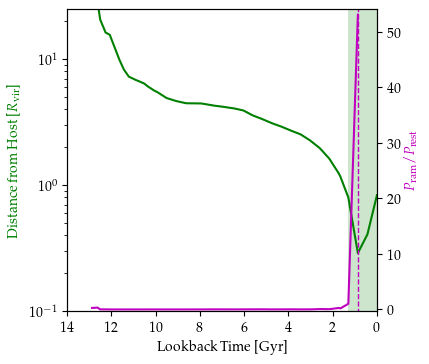

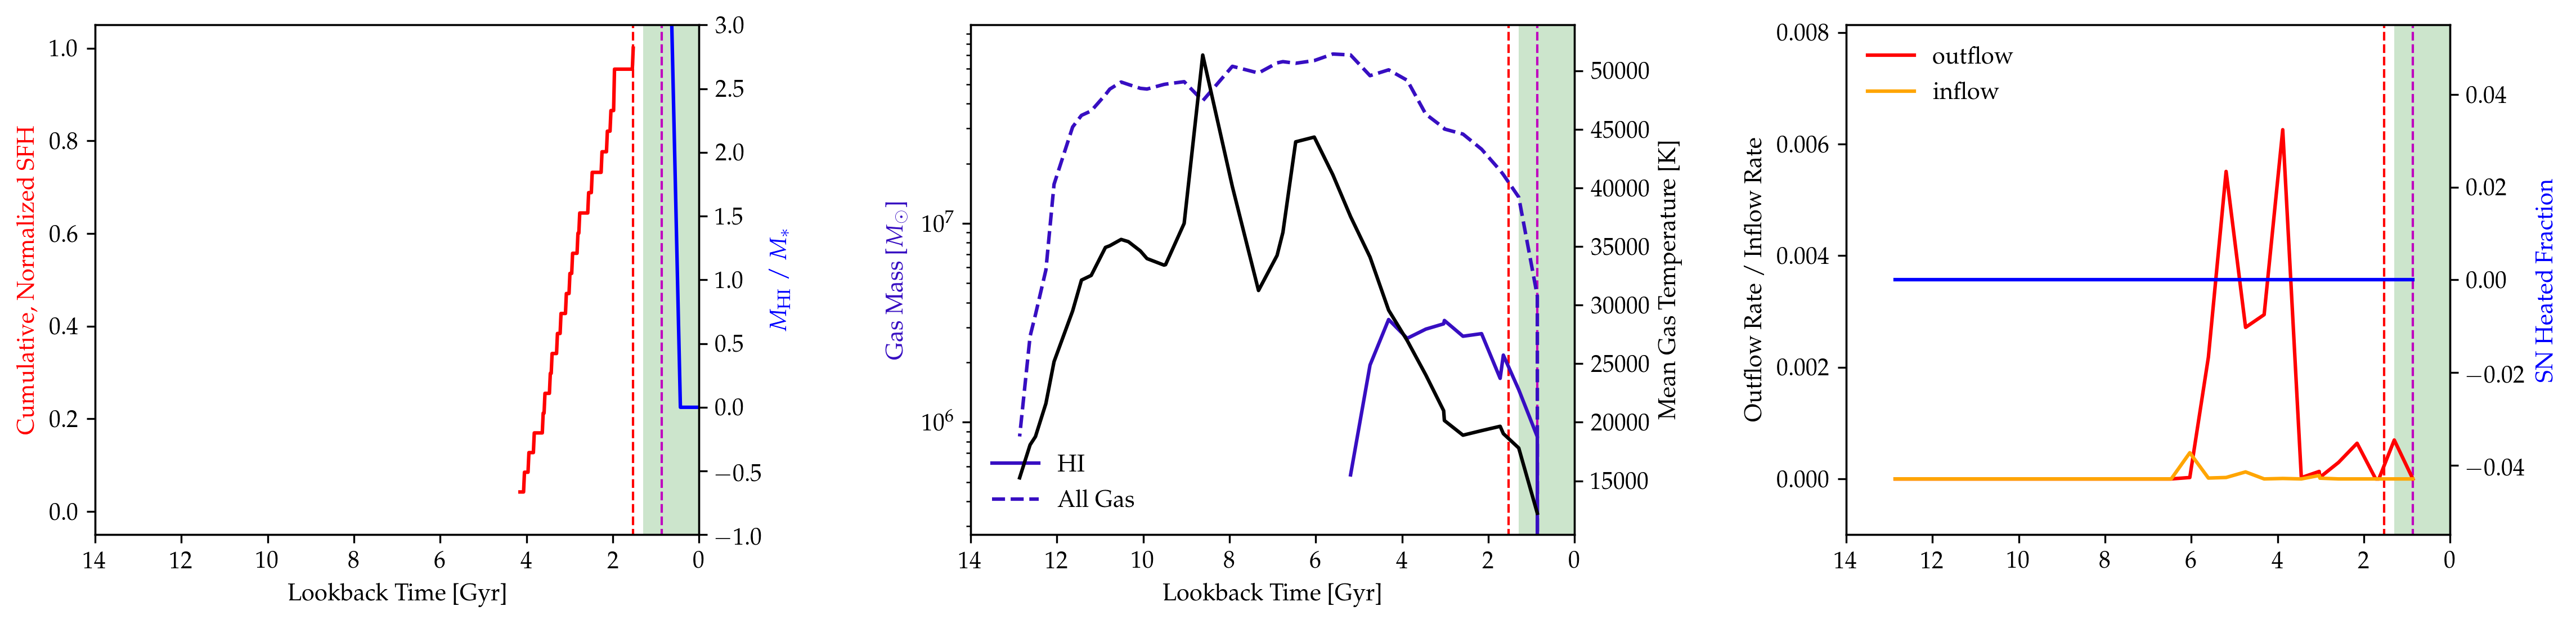

In [18]:
CaseStudyPlots('h148',36)

Snapshot h148.cosmo50PLK.3072g3HbwK1BH.002088
Centering...
Generating Image..., width 200 kpc


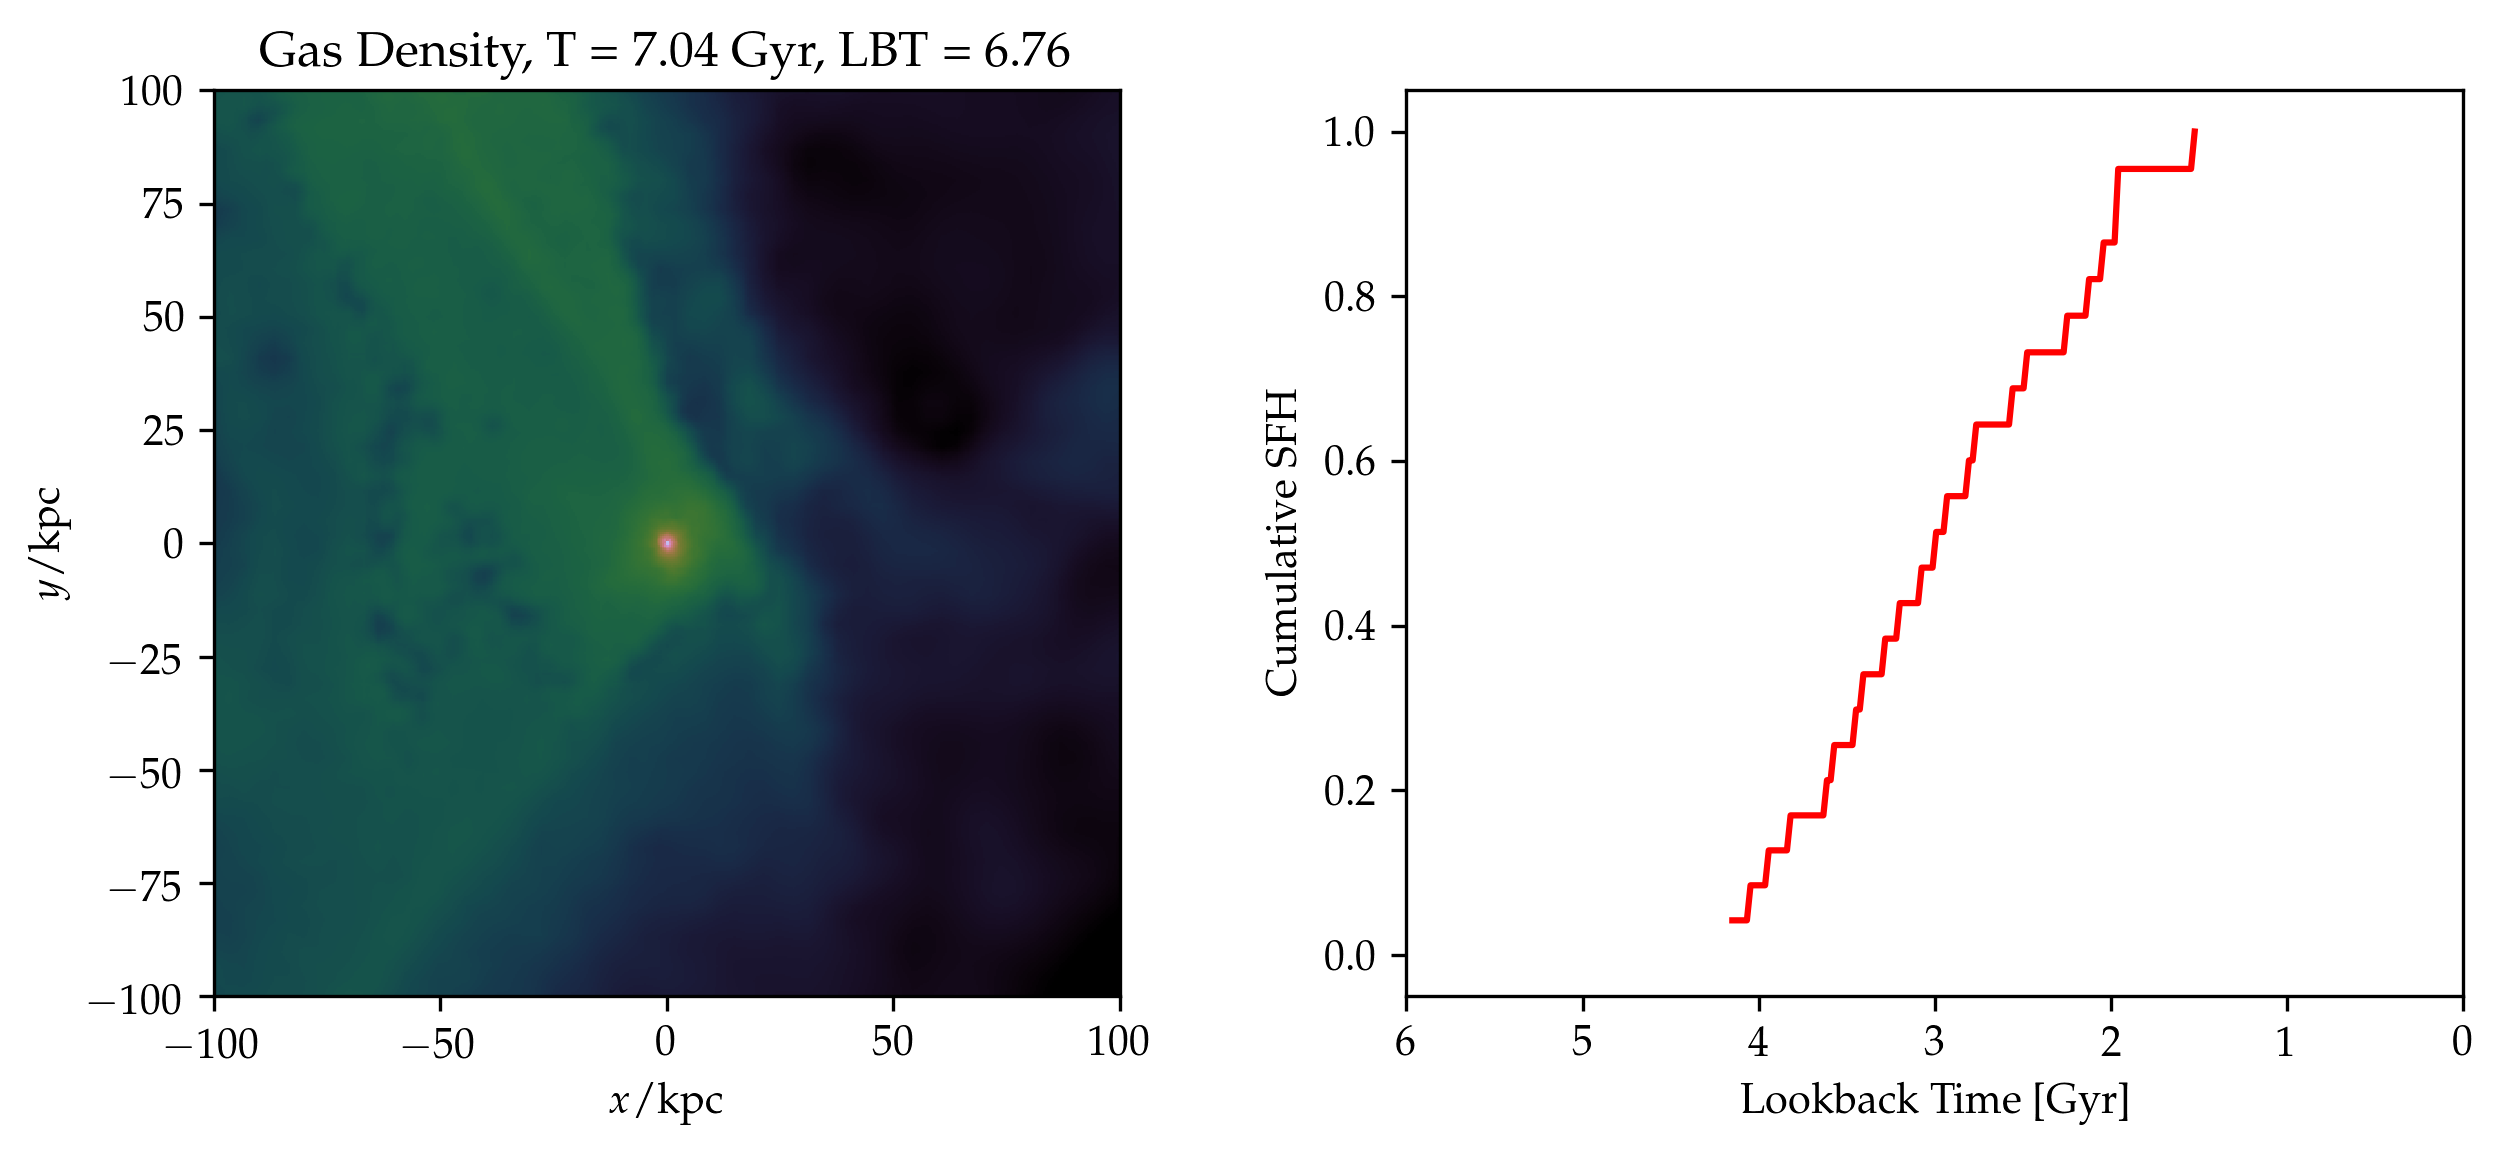

Snapshot h148.cosmo50PLK.3072g3HbwK1BH.002176
Centering...
Generating Image..., width 200 kpc


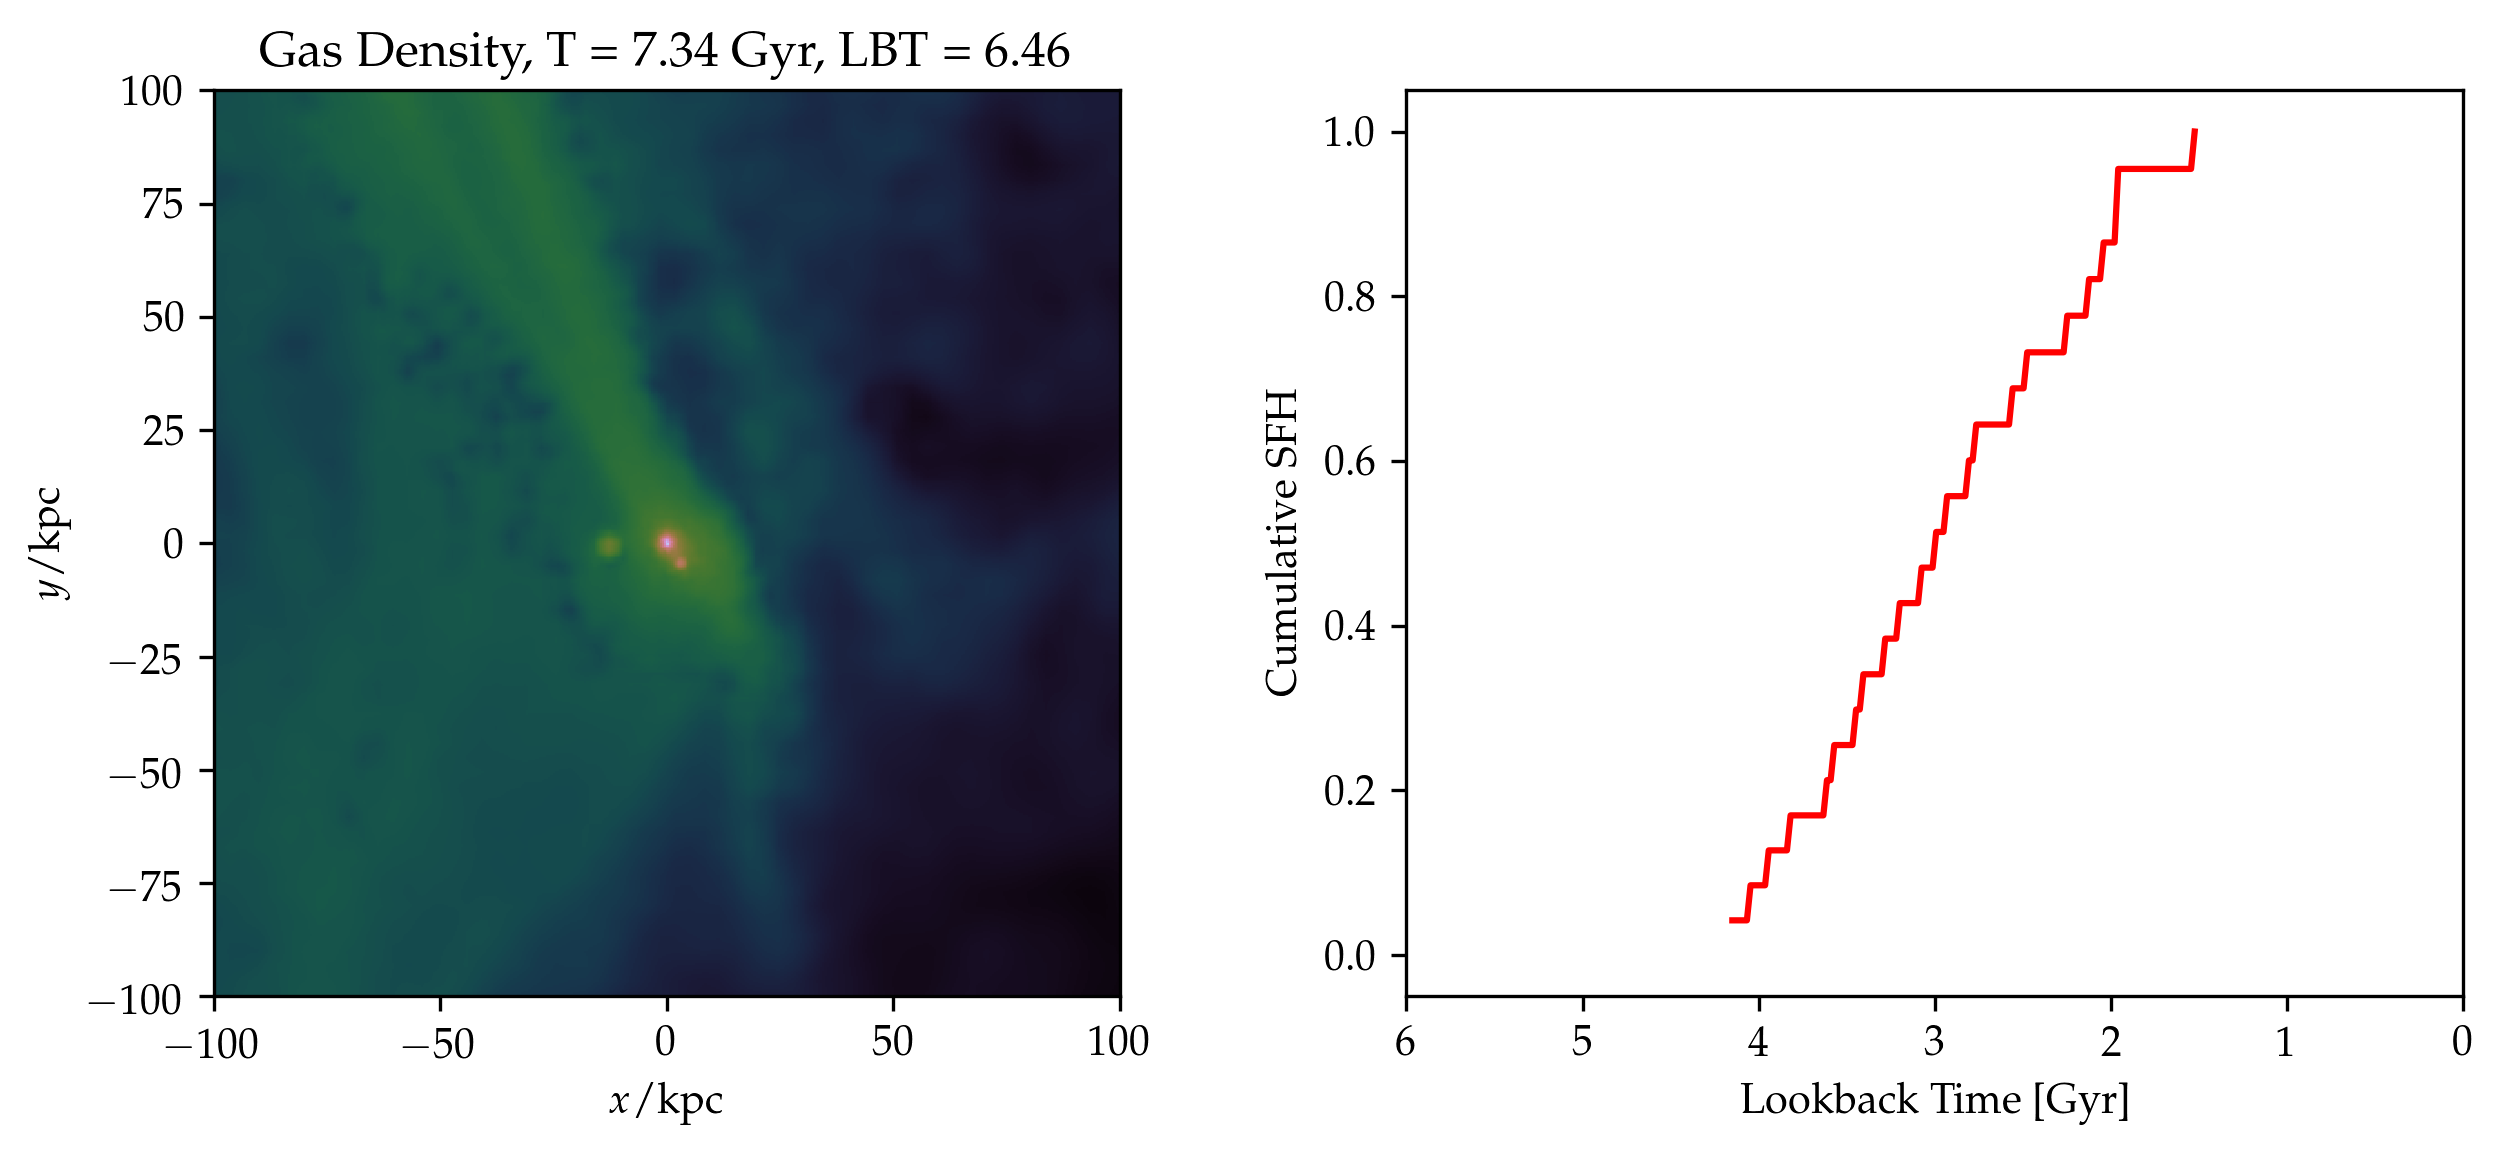

Snapshot h148.cosmo50PLK.3072g3HbwK1BH.002304
Centering...
Generating Image..., width 200 kpc


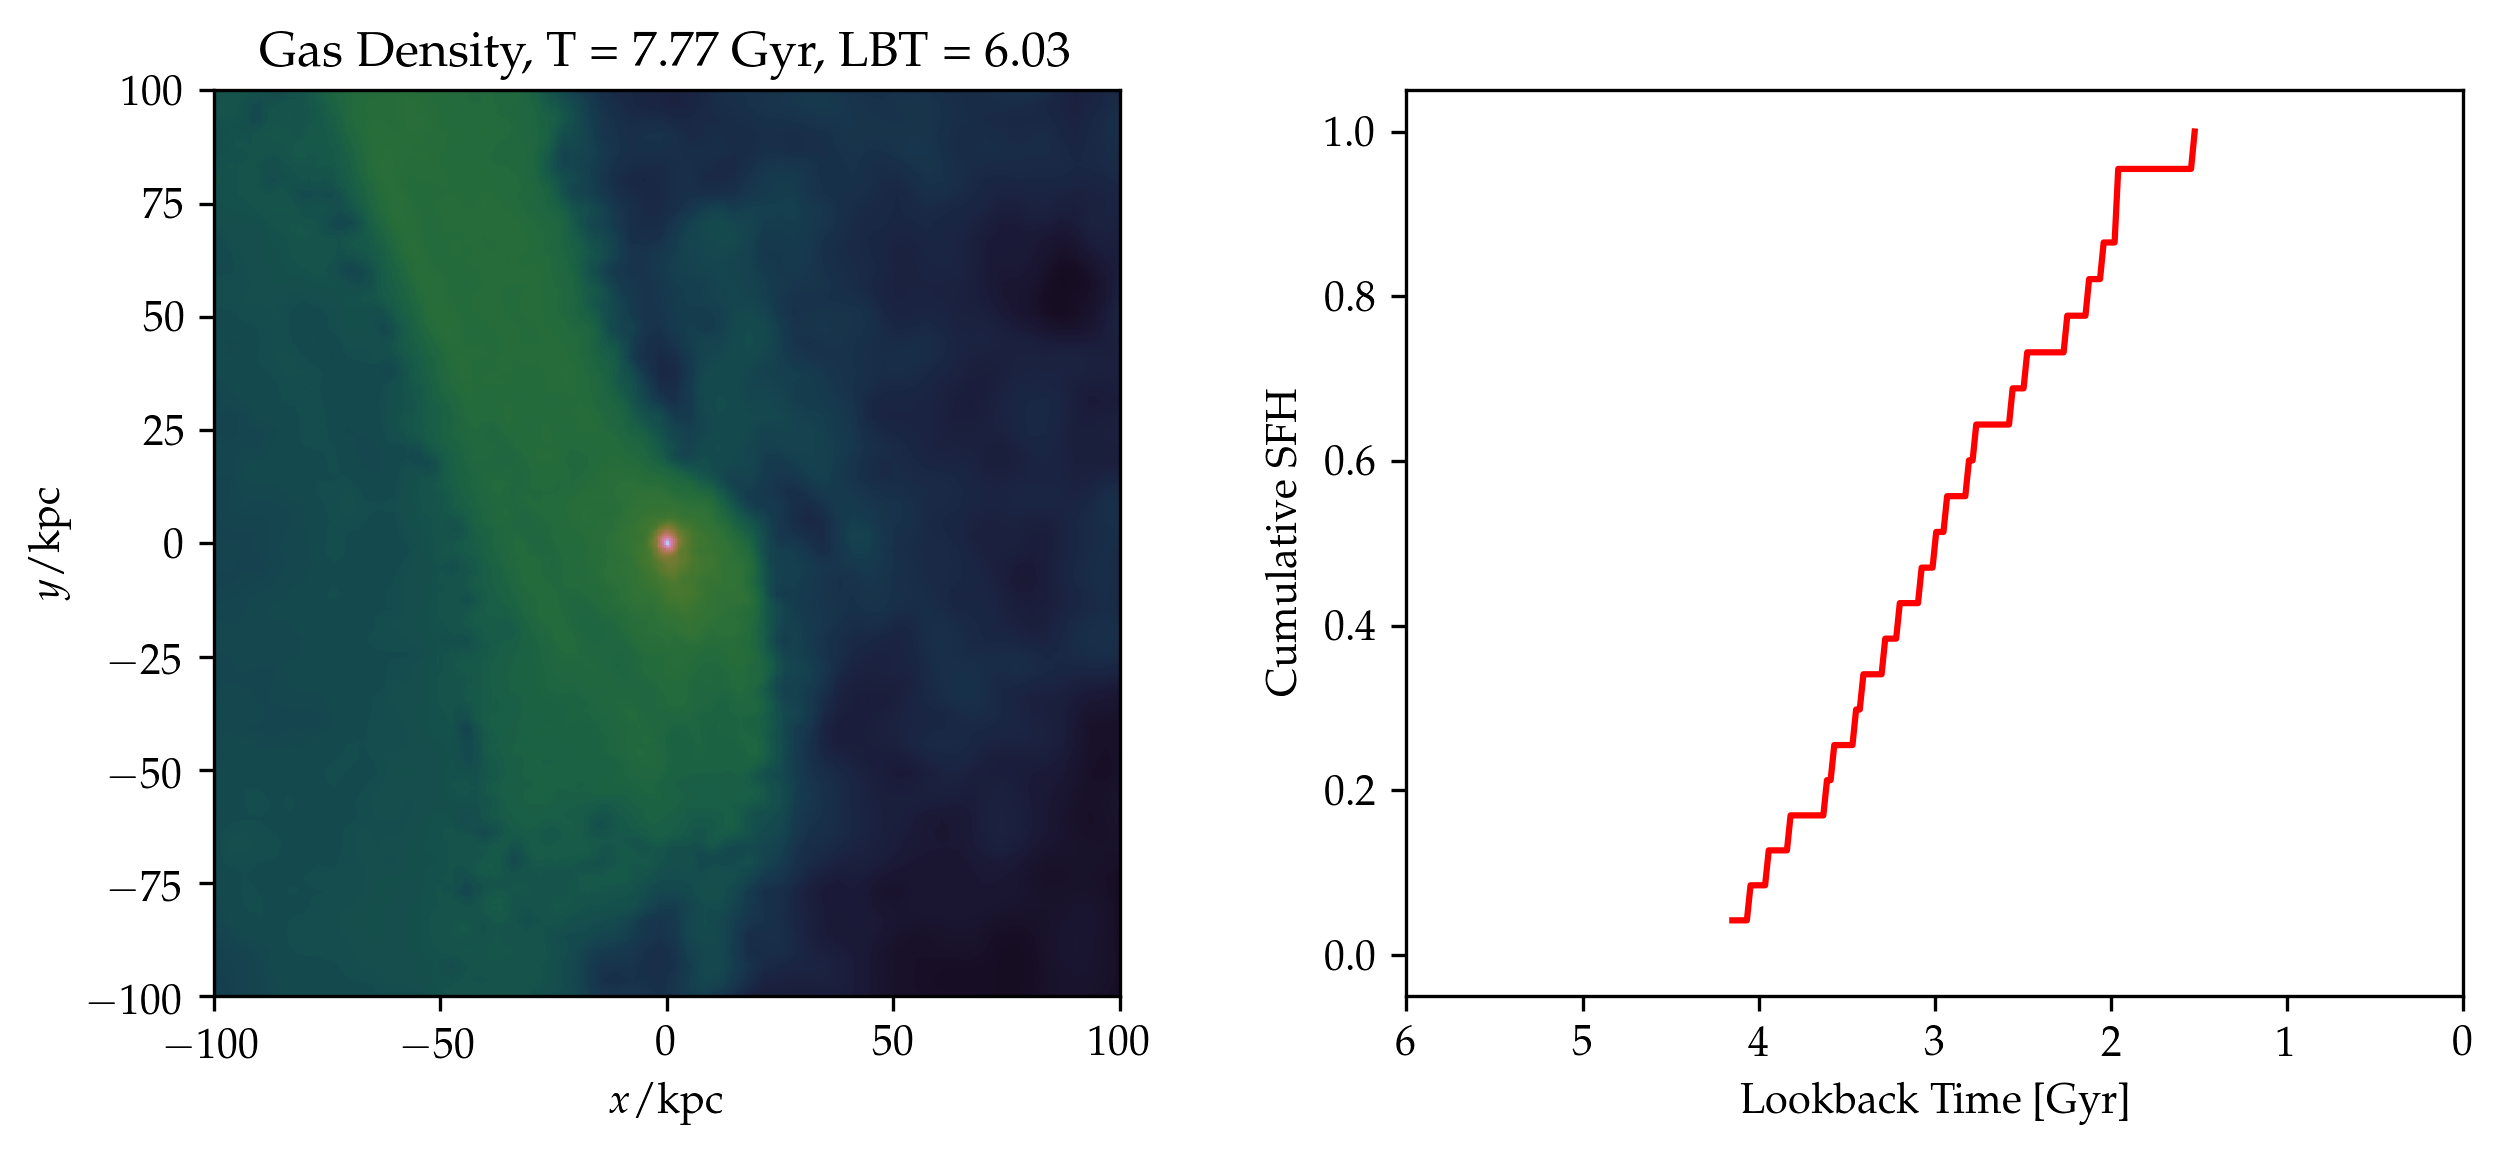

Snapshot h148.cosmo50PLK.3072g3HbwK1BH.002432
Centering...
Generating Image..., width 200 kpc


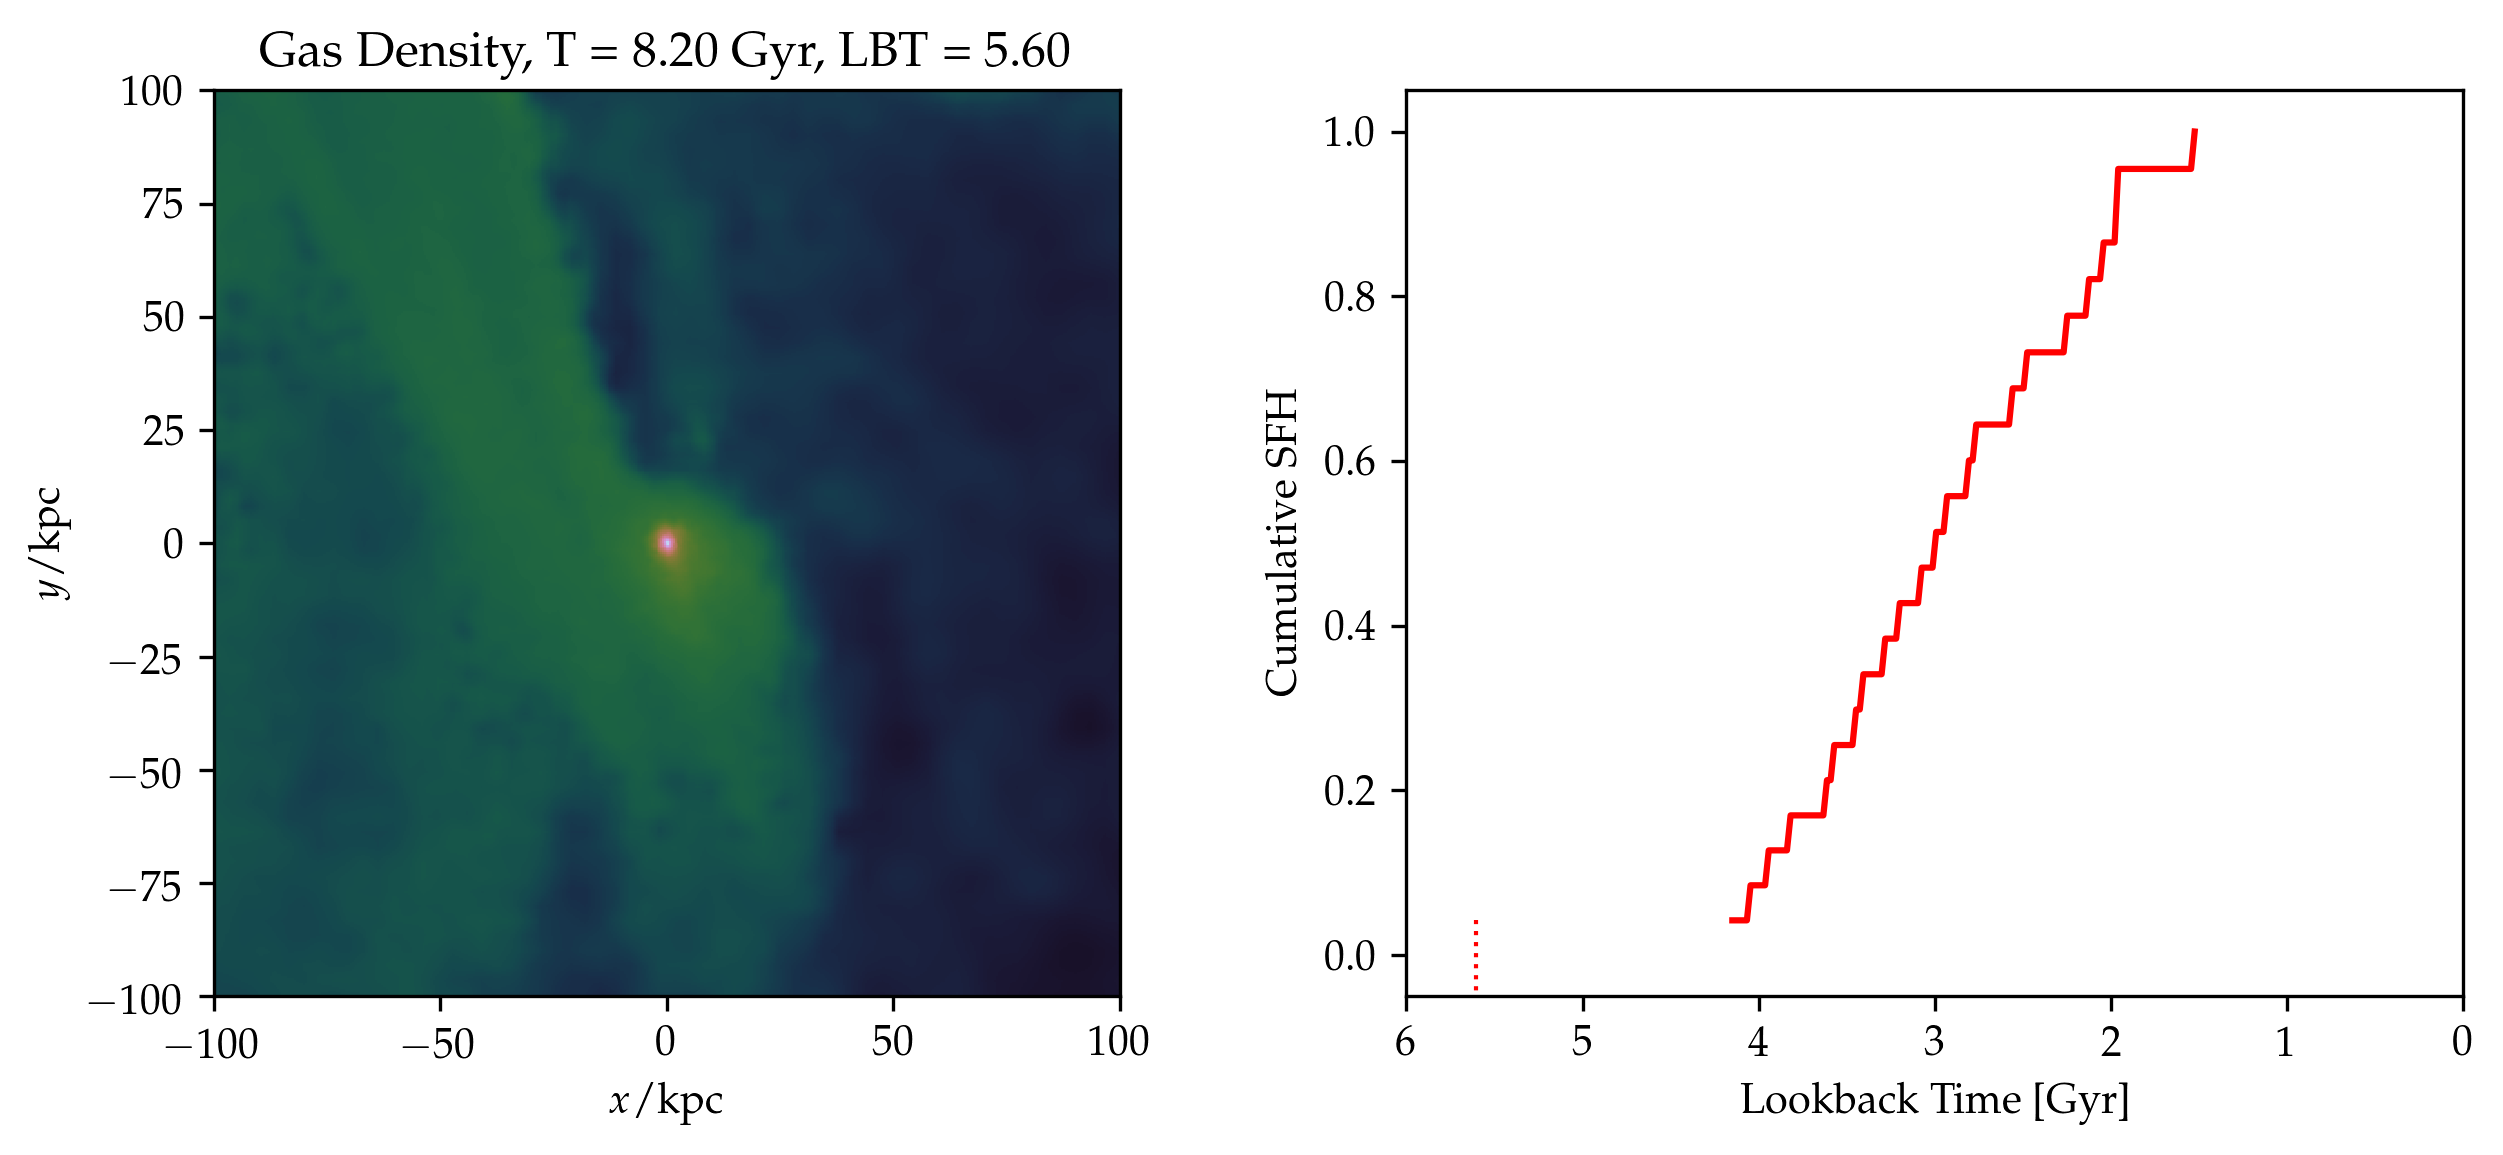

In [23]:
c_sfh, bc = cumulative_sfh('h148',36)
haloids = [36, 35, 31, 29, 30, 30, 30, 31, 29, 29, 32, 35, 36, 34, 31, 31, 34, 34, 35, 37, 39, 39, 47, 50, 56, 57, 60, 62, 62, 62, 72, 78, 93, 105, 126, 218, 367, 494, 555, 893]
snapshots = ['h148.cosmo50PLK.3072g3HbwK1BH.004096', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003968', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003840', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003712', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003606', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003584', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003456', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003328', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003200', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003195', 
             'h148.cosmo50PLK.3072g3HbwK1BH.003072', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002944', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002816', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002688', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002554', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002432', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002304', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002176', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002088', 
             'h148.cosmo50PLK.3072g3HbwK1BH.002048', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001920', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001740', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001536', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001408', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001280', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001269', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001152', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001106', 
             'h148.cosmo50PLK.3072g3HbwK1BH.001024', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000974', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000896', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000866', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000768', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000701', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000640', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000512', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000456', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000384', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000347', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000275', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000225', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000188', 
             'h148.cosmo50PLK.3072g3HbwK1BH.000139']

for haloid, snapshot in zip(np.flip(haloids[15:19]),np.flip(snapshots[15:19])):
        print('Snapshot %s' % snapshot)
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/'+snapshot)
        s.physical_units()
        h = s.halos()
        halo = h[haloid]
        rvir = int(float(halo.properties['Rvir']))
        print('Centering...')
        pynbody.analysis.halo.center(halo)

        width = 200
        age = 13.800797497330507
        time = float(halo.properties['time'].in_units('Gyr'))

        %matplotlib inline
        fig, ax = plt.subplots(1,2,figsize=(10,4), dpi=300)
        print('Generating Image..., width %s kpc' % width)
        pynbody.plot.sph.image(s.g, cmap='cubehelix', width='%s kpc' % width, subplot = ax[0], vmin=1e1, vmax=1e8,show_cbar=False,title=f'Gas Density, T = {time:.2f} Gyr, LBT = {age-time:.2f}')
        
        try:
            c_sfh_current = np.min(c_sfh[bc < (age-time)])
        except:
            c_sfh_current = 1
        ax[1].plot(bc,c_sfh,'r-')
        ax[1].plot([age-time,age-time],[-1,c_sfh_current], 'r:', linewidth=1)
        ax[1].set_ylim(-0.05,1.05)
        ax[1].set_xlim(6,0)
        ax[1].set_xlabel('Lookback Time [Gyr]')
        ax[1].set_ylabel('Cumulative SFH')

        plt.savefig('h148_36_Movie/%s.png' % snapshot, dpi=300)
        plt.show()



In [24]:
import imageio
import os

path = '/home/akinshol/Data/Timescales/h148_36_Movie/'

image_folder = os.fsencode(path)
filenames = []
for file in os.listdir(image_folder):
    filename = os.fsdecode(file)
    if filename.endswith('.png'):
        filenames.append(filename)
    
filenames.sort()
print(filenames)

images = list(map(lambda filename: imageio.imread(path+filename), filenames))

s = 30

imageio.mimsave('movie_h148_36.gif', images, duration = s/60)

['h148.cosmo50PLK.3072g3HbwK1BH.002088.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002176.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002304.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002432.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002554.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002688.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002816.png', 'h148.cosmo50PLK.3072g3HbwK1BH.002944.png', 'h148.cosmo50PLK.3072g3HbwK1BH.003072.png', 'h148.cosmo50PLK.3072g3HbwK1BH.003195.png', 'h148.cosmo50PLK.3072g3HbwK1BH.003200.png', 'h148.cosmo50PLK.3072g3HbwK1BH.003328.png', 'h148.cosmo50PLK.3072g3HbwK1BH.003456.png', 'h148.cosmo50PLK.3072g3HbwK1BH.003584.png']
